Data can be found here: https://www.kaggle.com/datasets/uciml/faulty-steel-plates

# EDA

## Statistics

In [1]:
import io
import contextlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
from utils import fttransformer, evaluate_synthetic, ctgan_oversampling, smotenc, nn_optimization
from utils.general import rounded_mean, metrics_of_prediction, plot_cm, scale_df, preprocess_df
import optuna
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

2025-03-02 12:29:29.324497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 12:29:29.369065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 12:29:29.370019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-02 12:29:30.337834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


load and display the dataset

In [2]:
df = pd.read_csv('csv/faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


General infos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} features, while having {df.isnull().sum().sum()} null values.')
print(f'Features have data type {df.dtypes.unique()[0]} and {df.dtypes.unique()[1]}.')

The dataset has 1941 rows and 34 features, while having 0 null values.
Features have data type int64 and float64.


Statistics about the features

In [5]:
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,1941.0,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03
X_Maximum,1941.0,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03
Y_Minimum,1941.0,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07
Y_Maximum,1941.0,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07
Pixels_Areas,1941.0,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05
X_Perimeter,1941.0,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04
Y_Perimeter,1941.0,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1941.0,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07
Minimum_of_Luminosity,1941.0,8.454869e+01,3.213428e+01,0.0000,63.0000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1941.0,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02


Lower the name of the columns

In [6]:
df.columns = map(str.lower, df.columns)

Create a column encoding the anomalies features


In [7]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']

# list of the features of the steel plates
feat_col = [x for x in df.columns if x not in target_cols]

# mapper for the encoding
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} 

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
df.drop(target_cols, axis = 1, inplace = True)
# remove troublesome outlier
df.drop(391, inplace = True)

## Histograms of the features

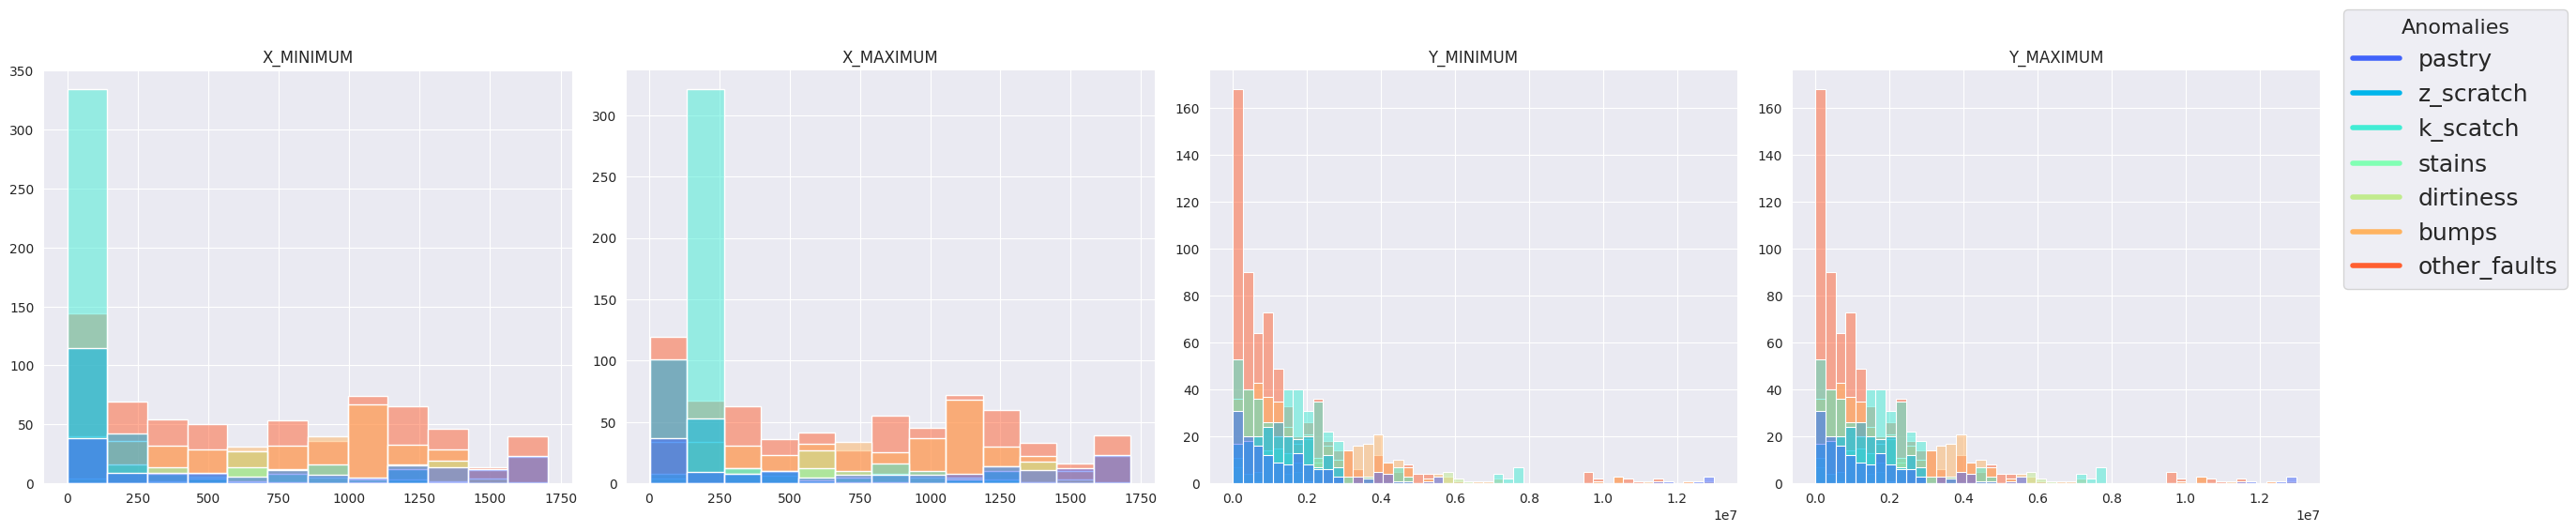

In [8]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

palette_hist = sns.color_palette('rainbow', n_colors = len(df['anomaly'].unique()))
hue_order = df['anomaly'].unique()

colors = sns.color_palette('rainbow', len(target_cols))
handles = [plt.Line2D([0], [0], color = colors[i], lw = 4, label = str(target_cols[i])) for i in range(len(target_cols))]

for index, col in enumerate(feat_col[:4]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

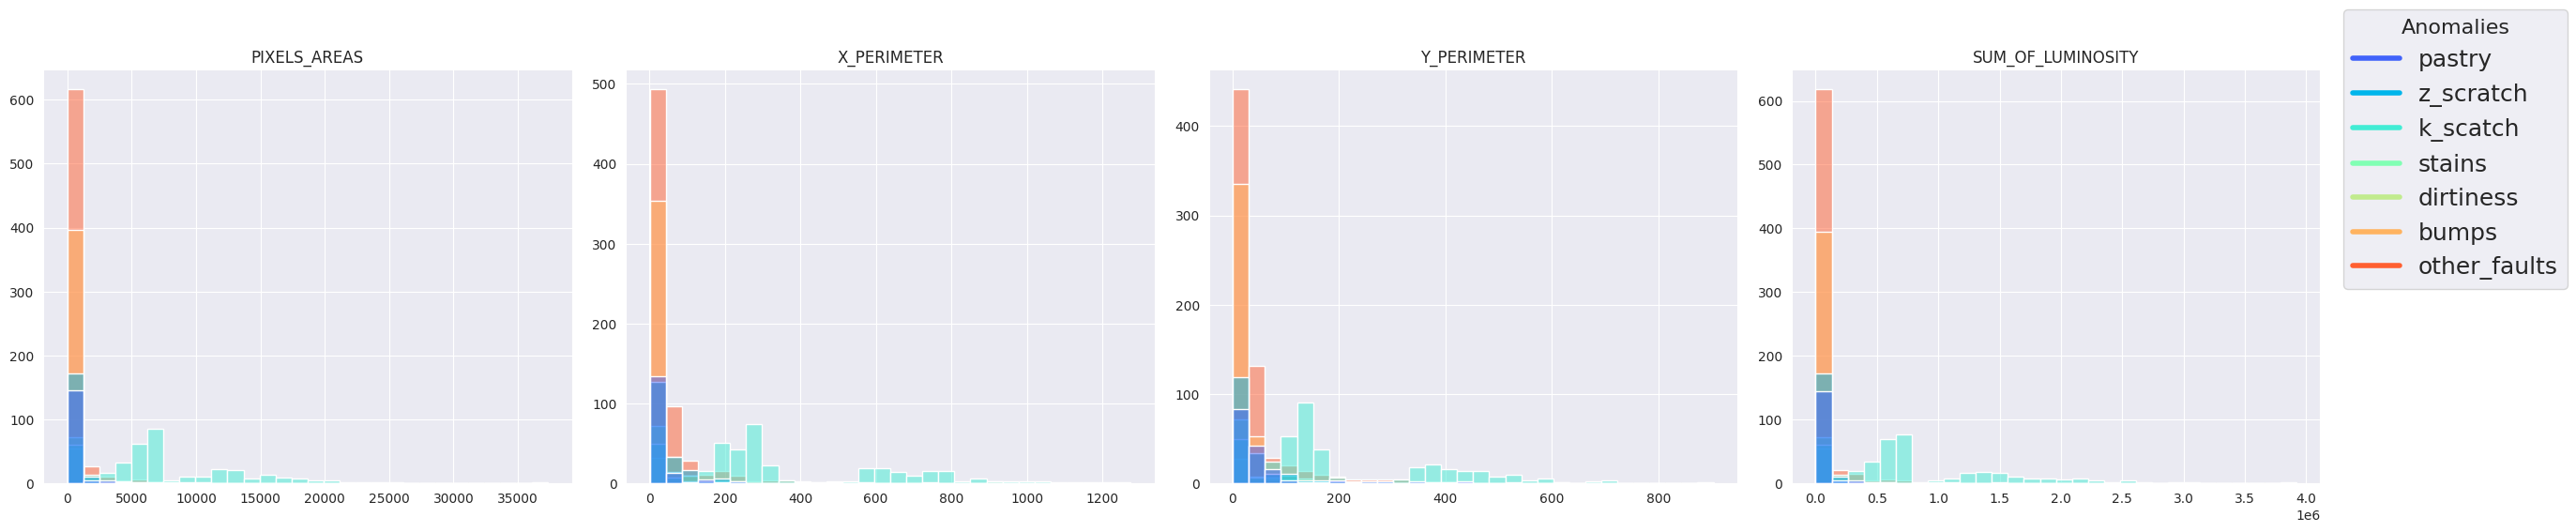

In [9]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False, bins = 30)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('') 

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

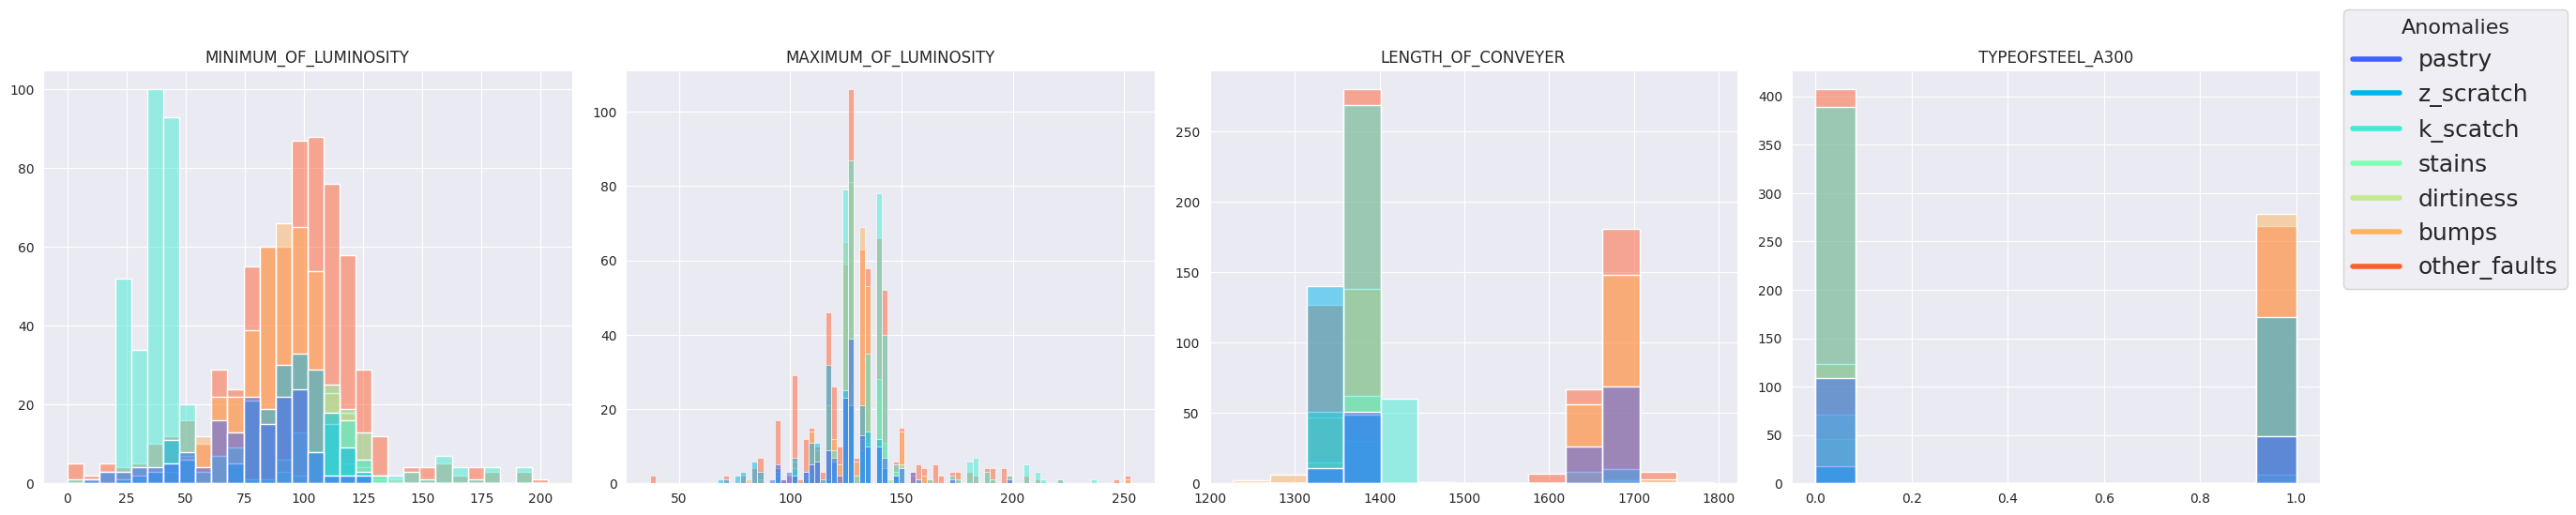

In [10]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

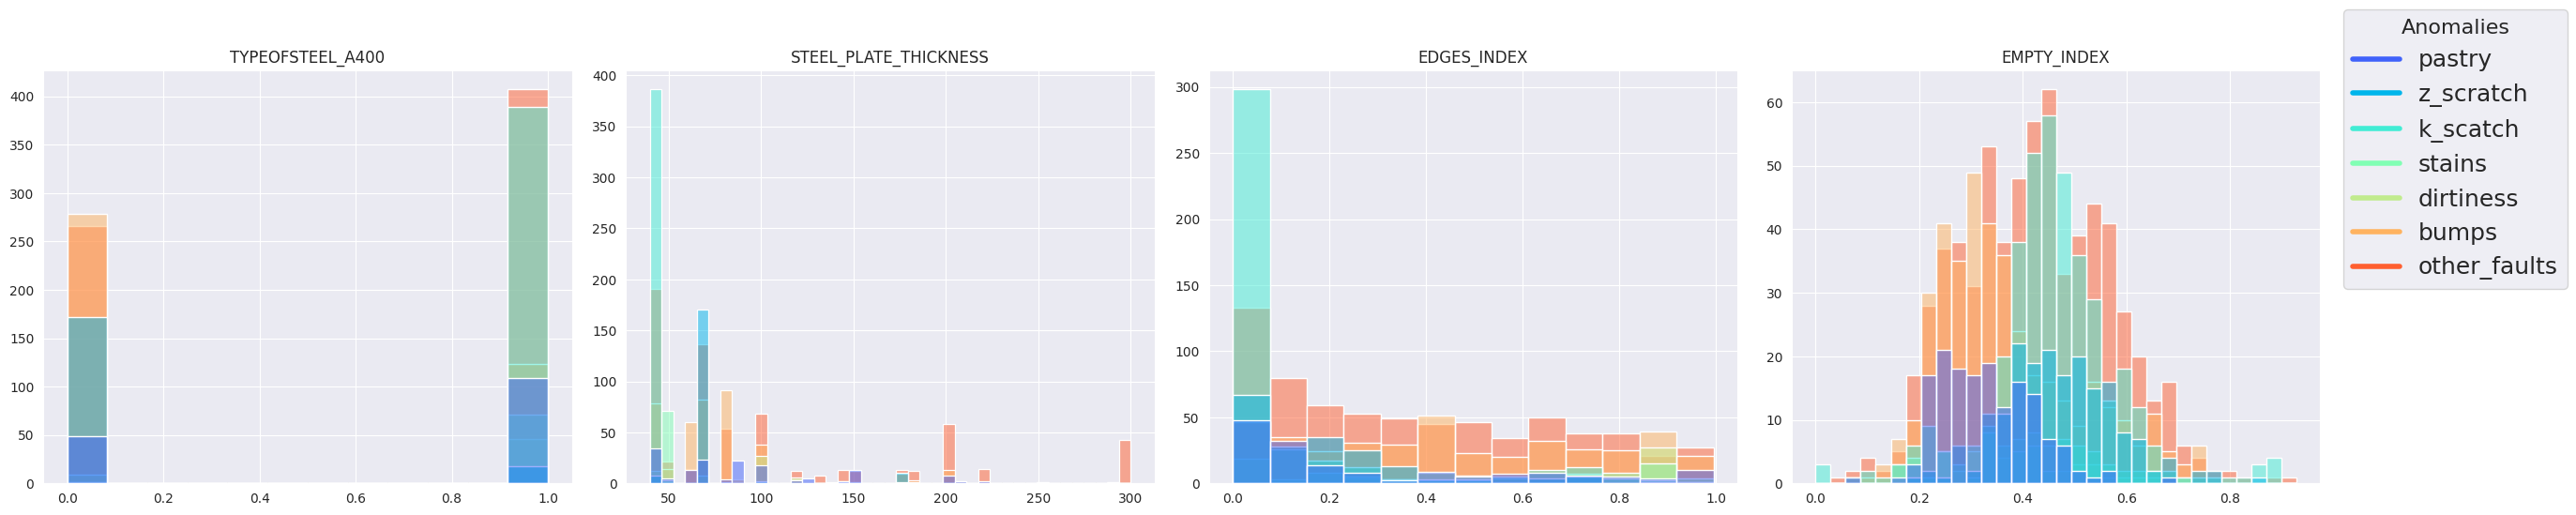

In [11]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

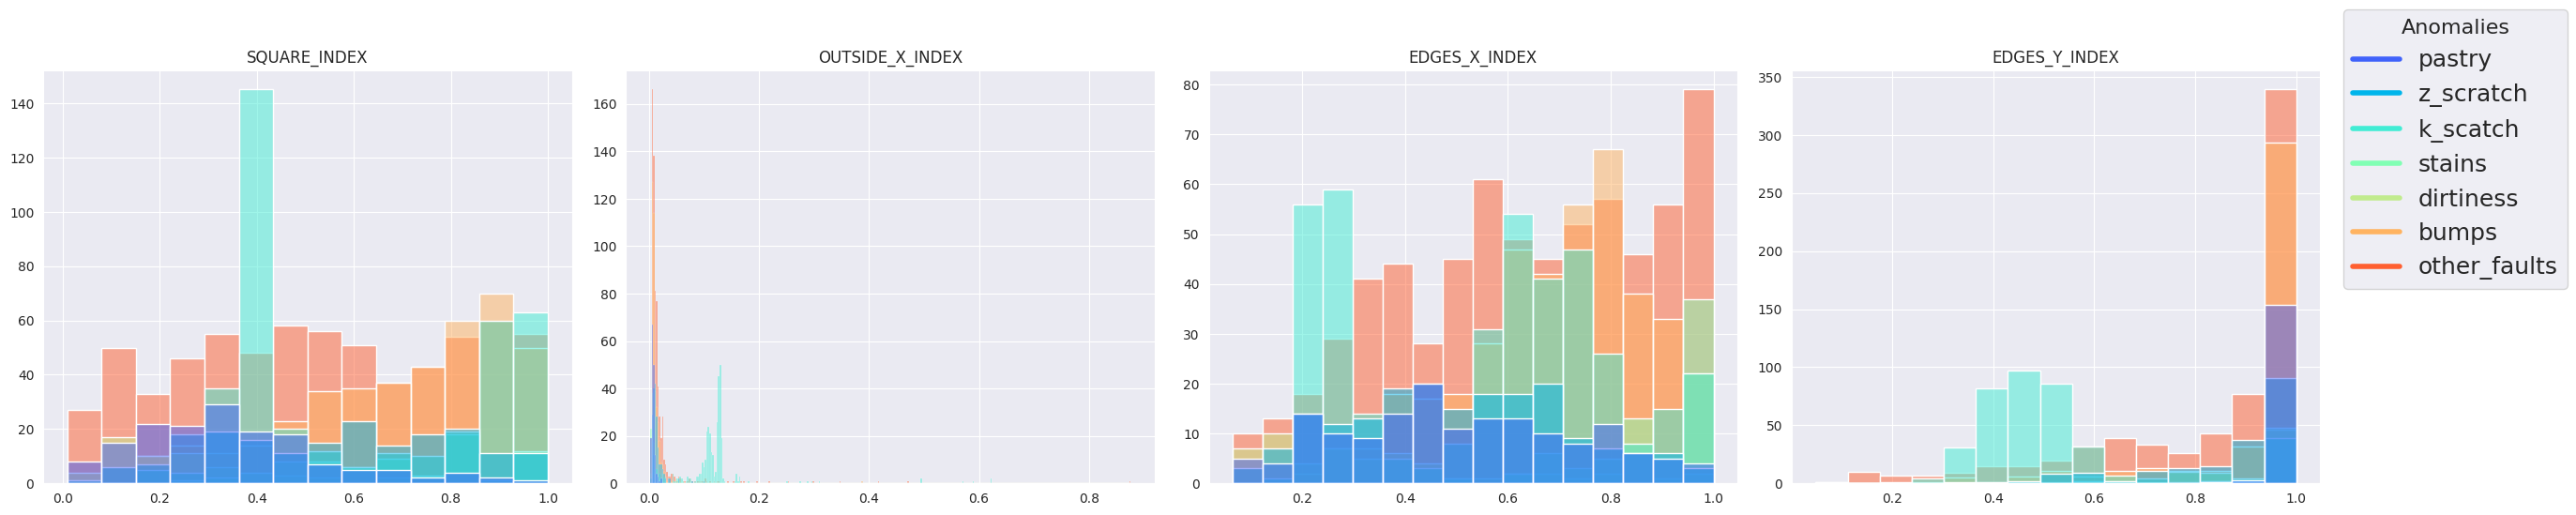

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

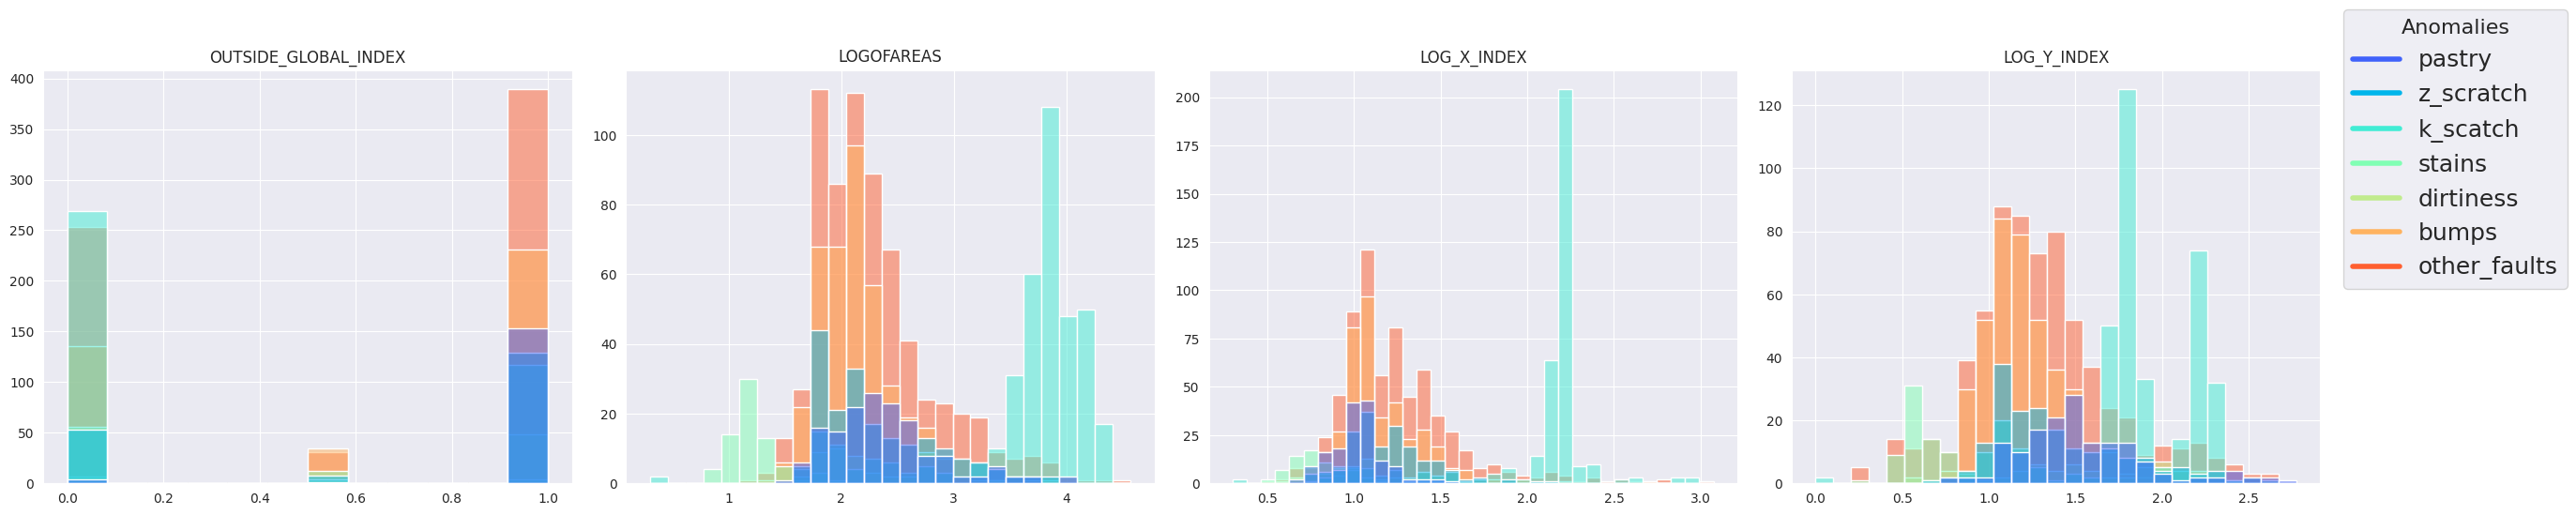

In [13]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

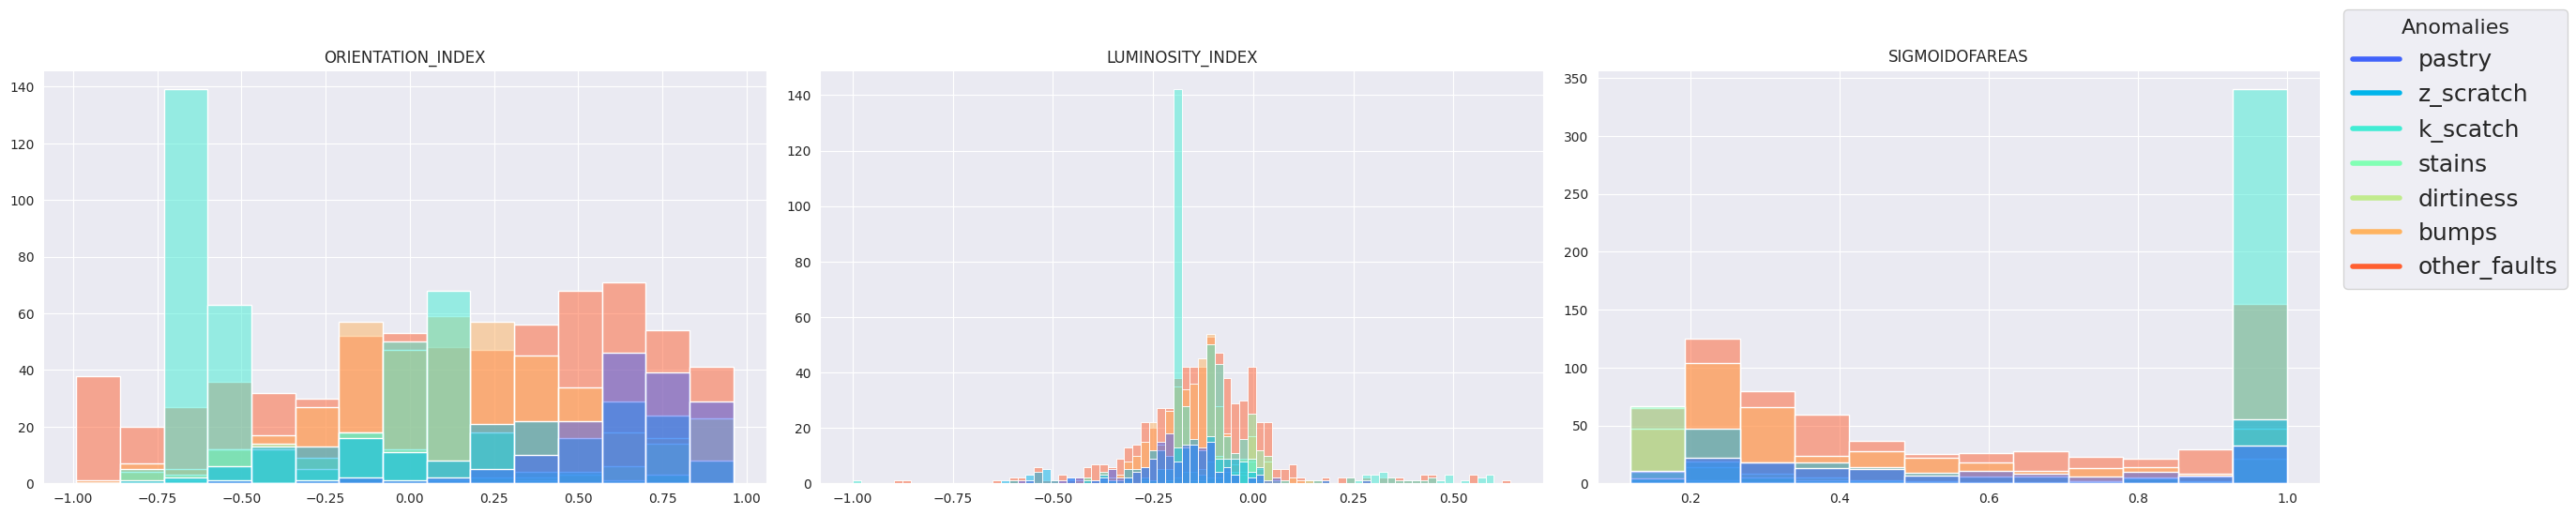

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

## Boxplots of the features

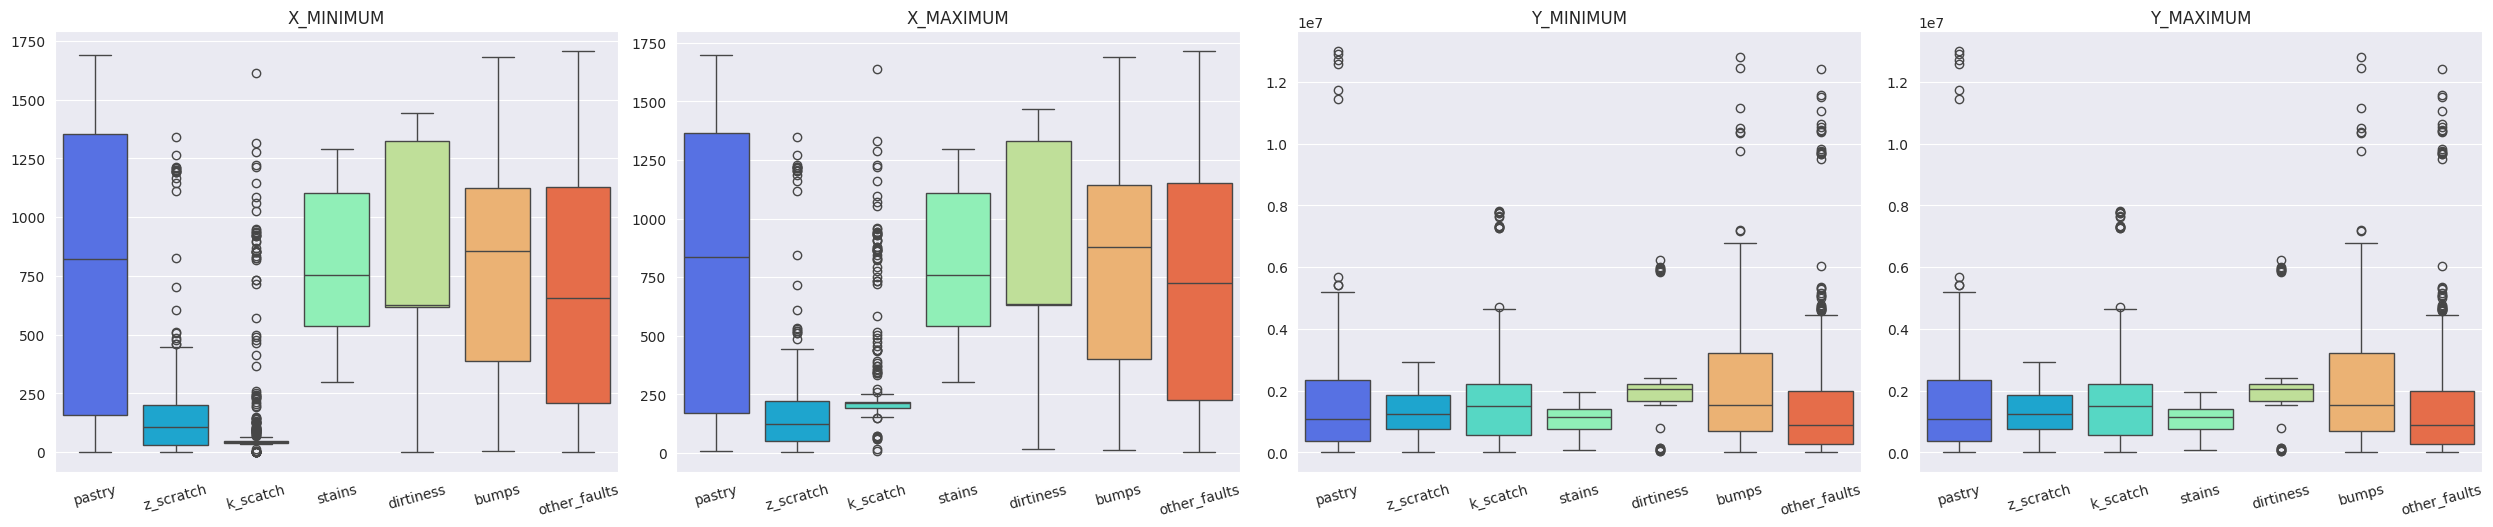

In [15]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[:4]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

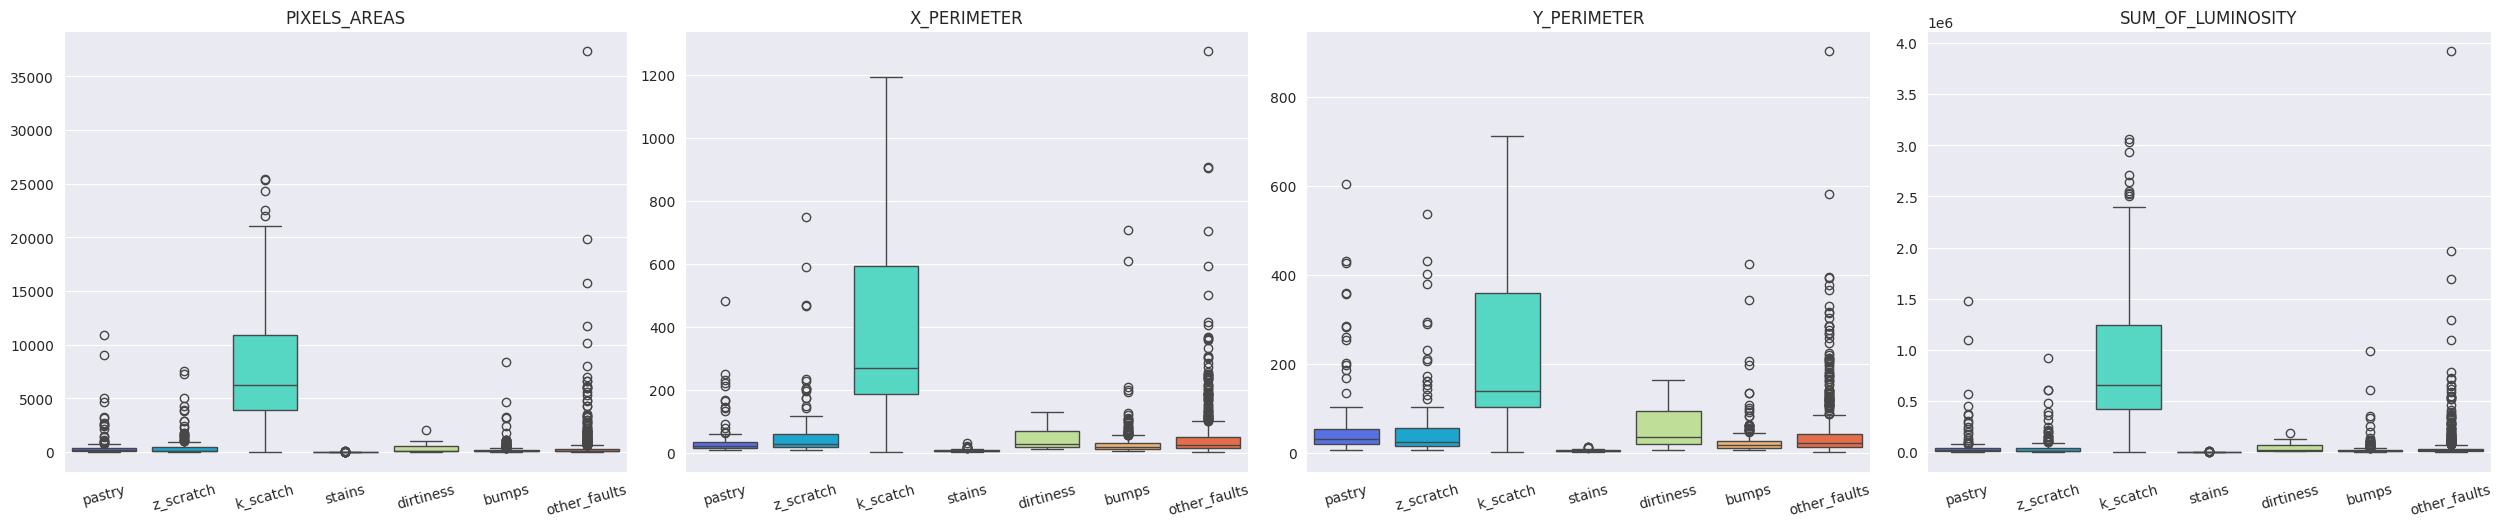

In [16]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

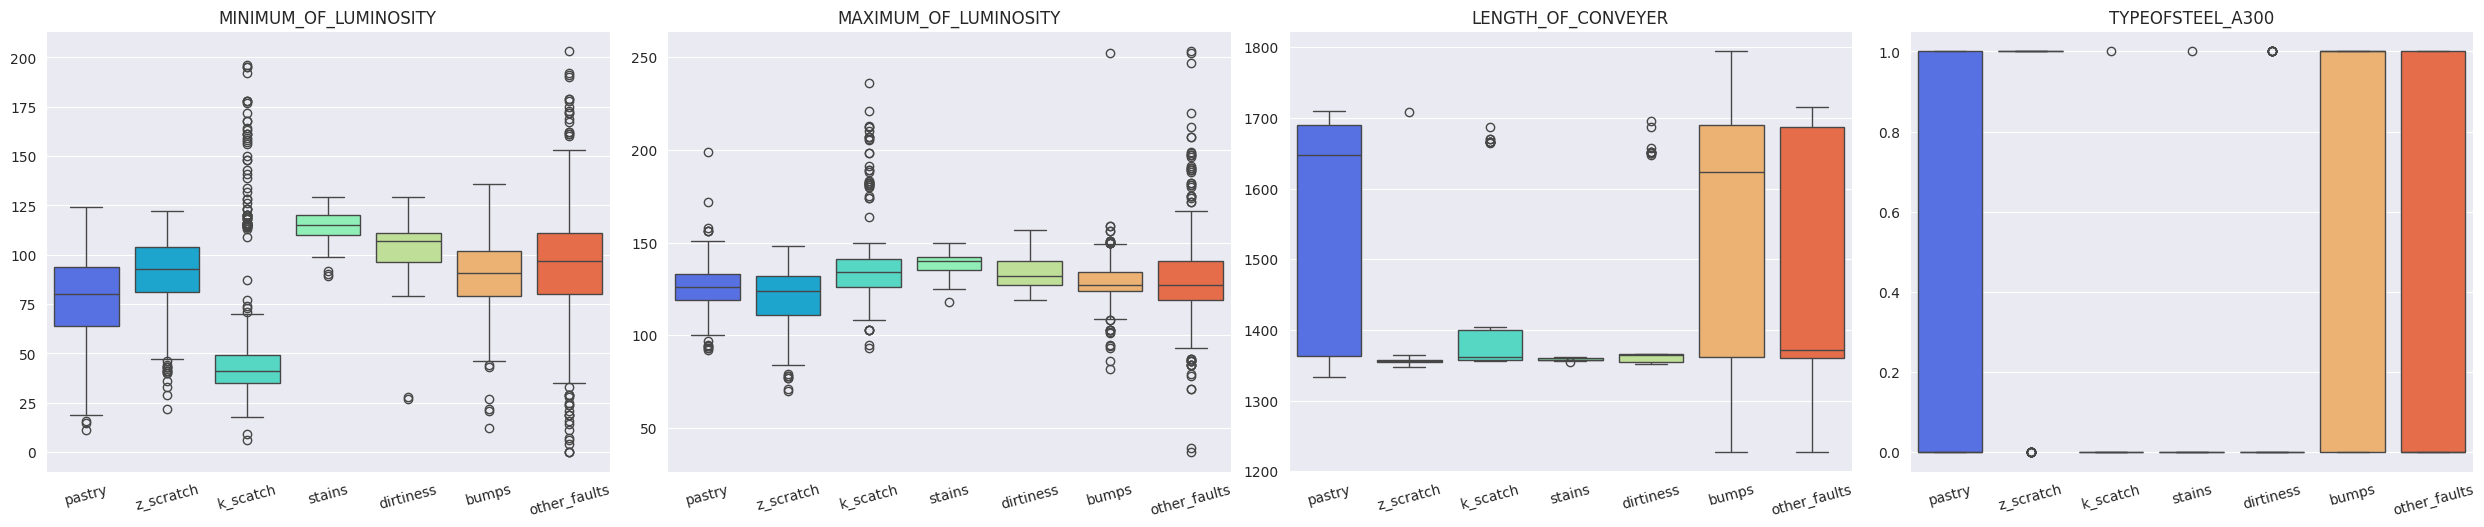

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

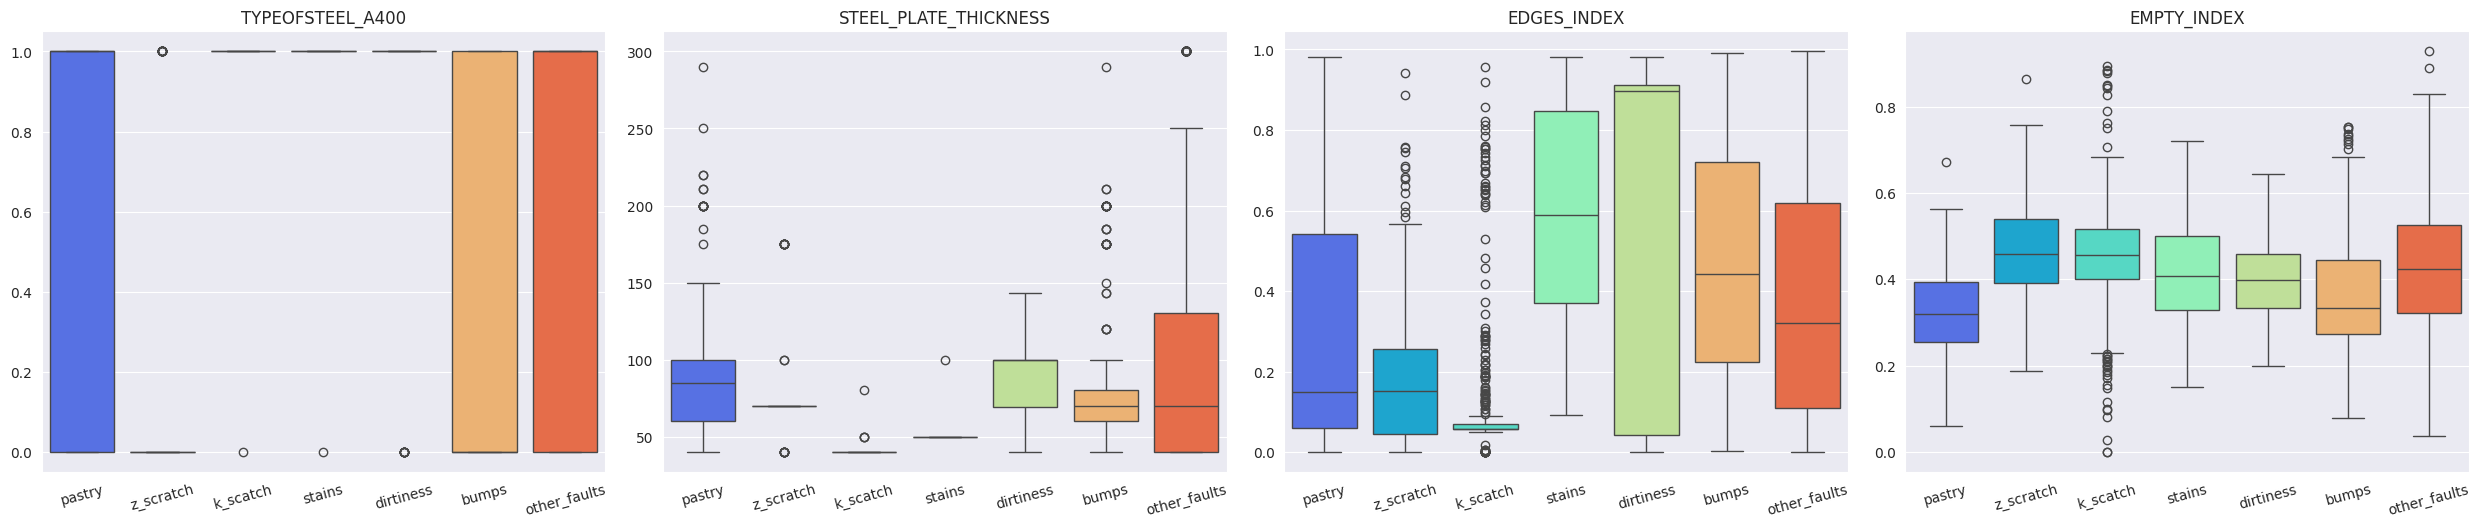

In [18]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

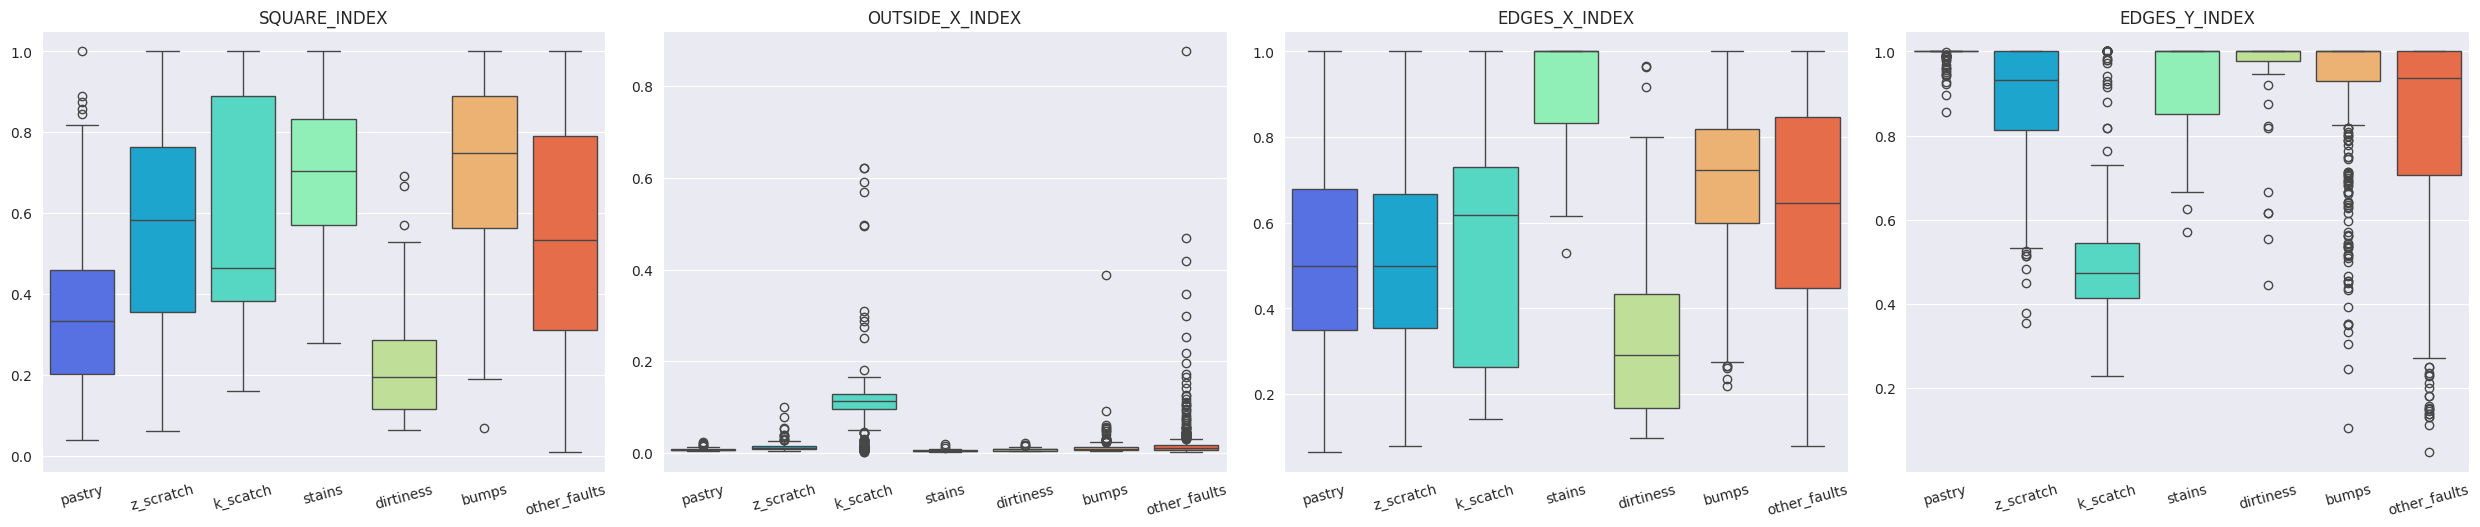

In [19]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

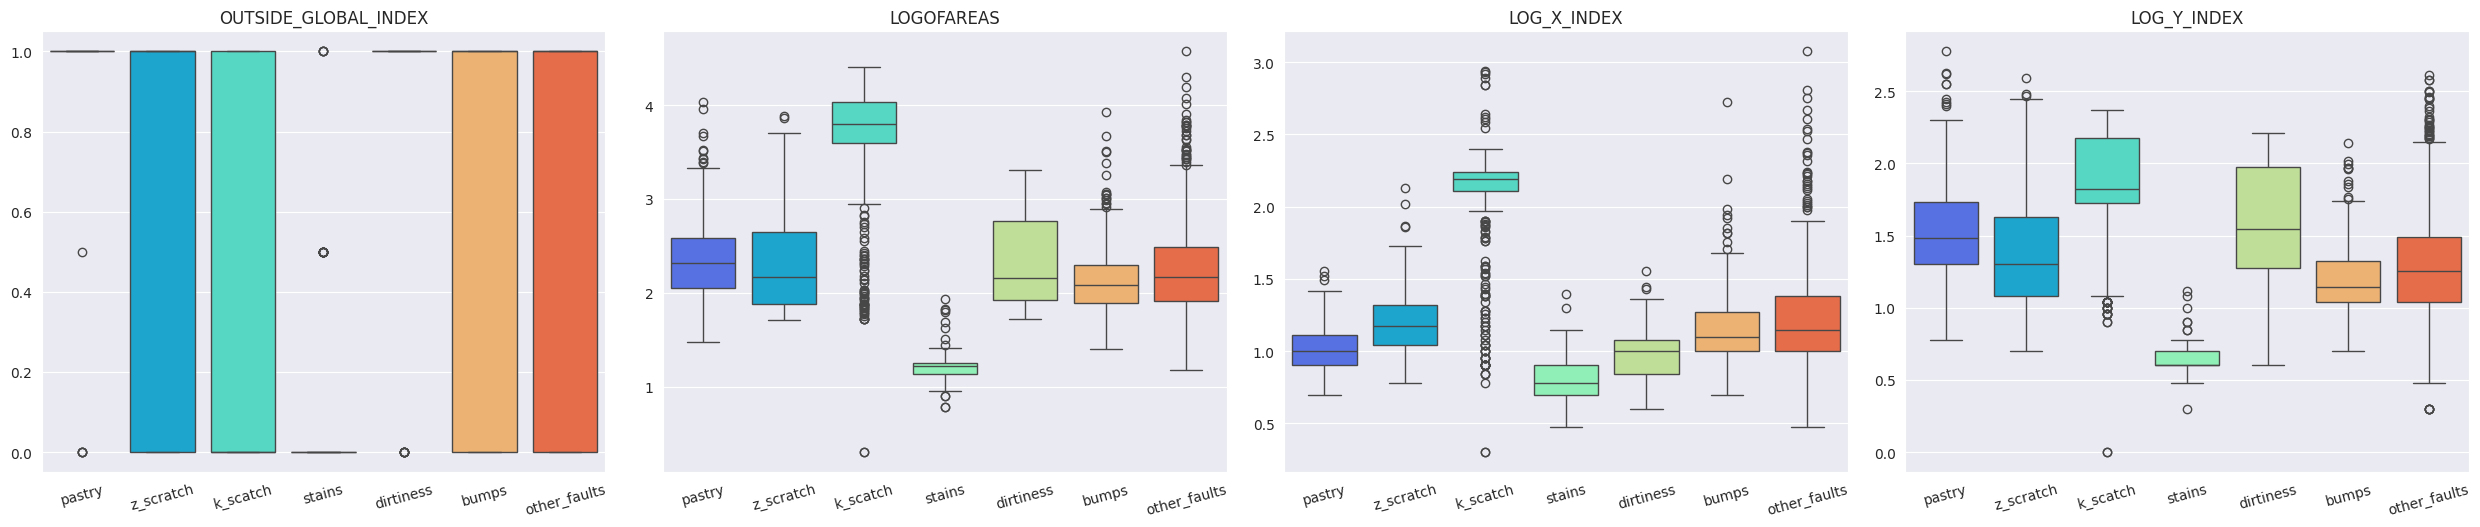

In [20]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

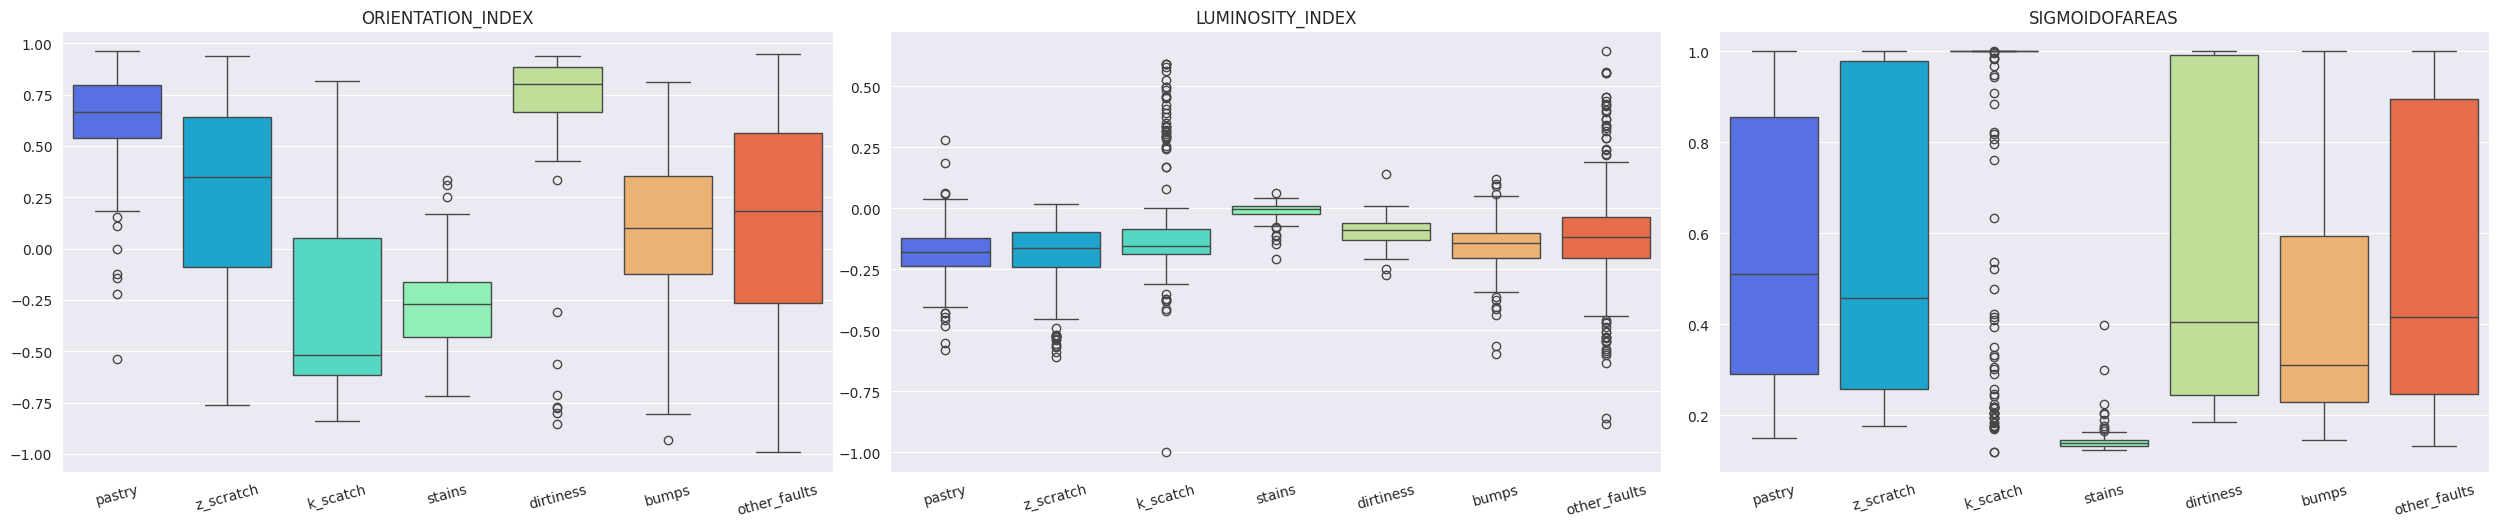

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

Check for binary features

In [22]:
for col in feat_col:
    if len(df[col].unique()) <= 2:
        print(f'Feature {col} has binary data (e.g. 0-1)')

# also check 'outside_global_index' feature
unique_ogi_feature = df['outside_global_index'].unique()
print(f'Feature outside_global_index has {len(unique_ogi_feature)} unique values, which are {str(unique_ogi_feature).strip("[").strip("]")}')

Feature typeofsteel_a300 has binary data (e.g. 0-1)
Feature typeofsteel_a400 has binary data (e.g. 0-1)
Feature outside_global_index has 3 unique values, which are 1.  0.5 0. 


# Correlation between features

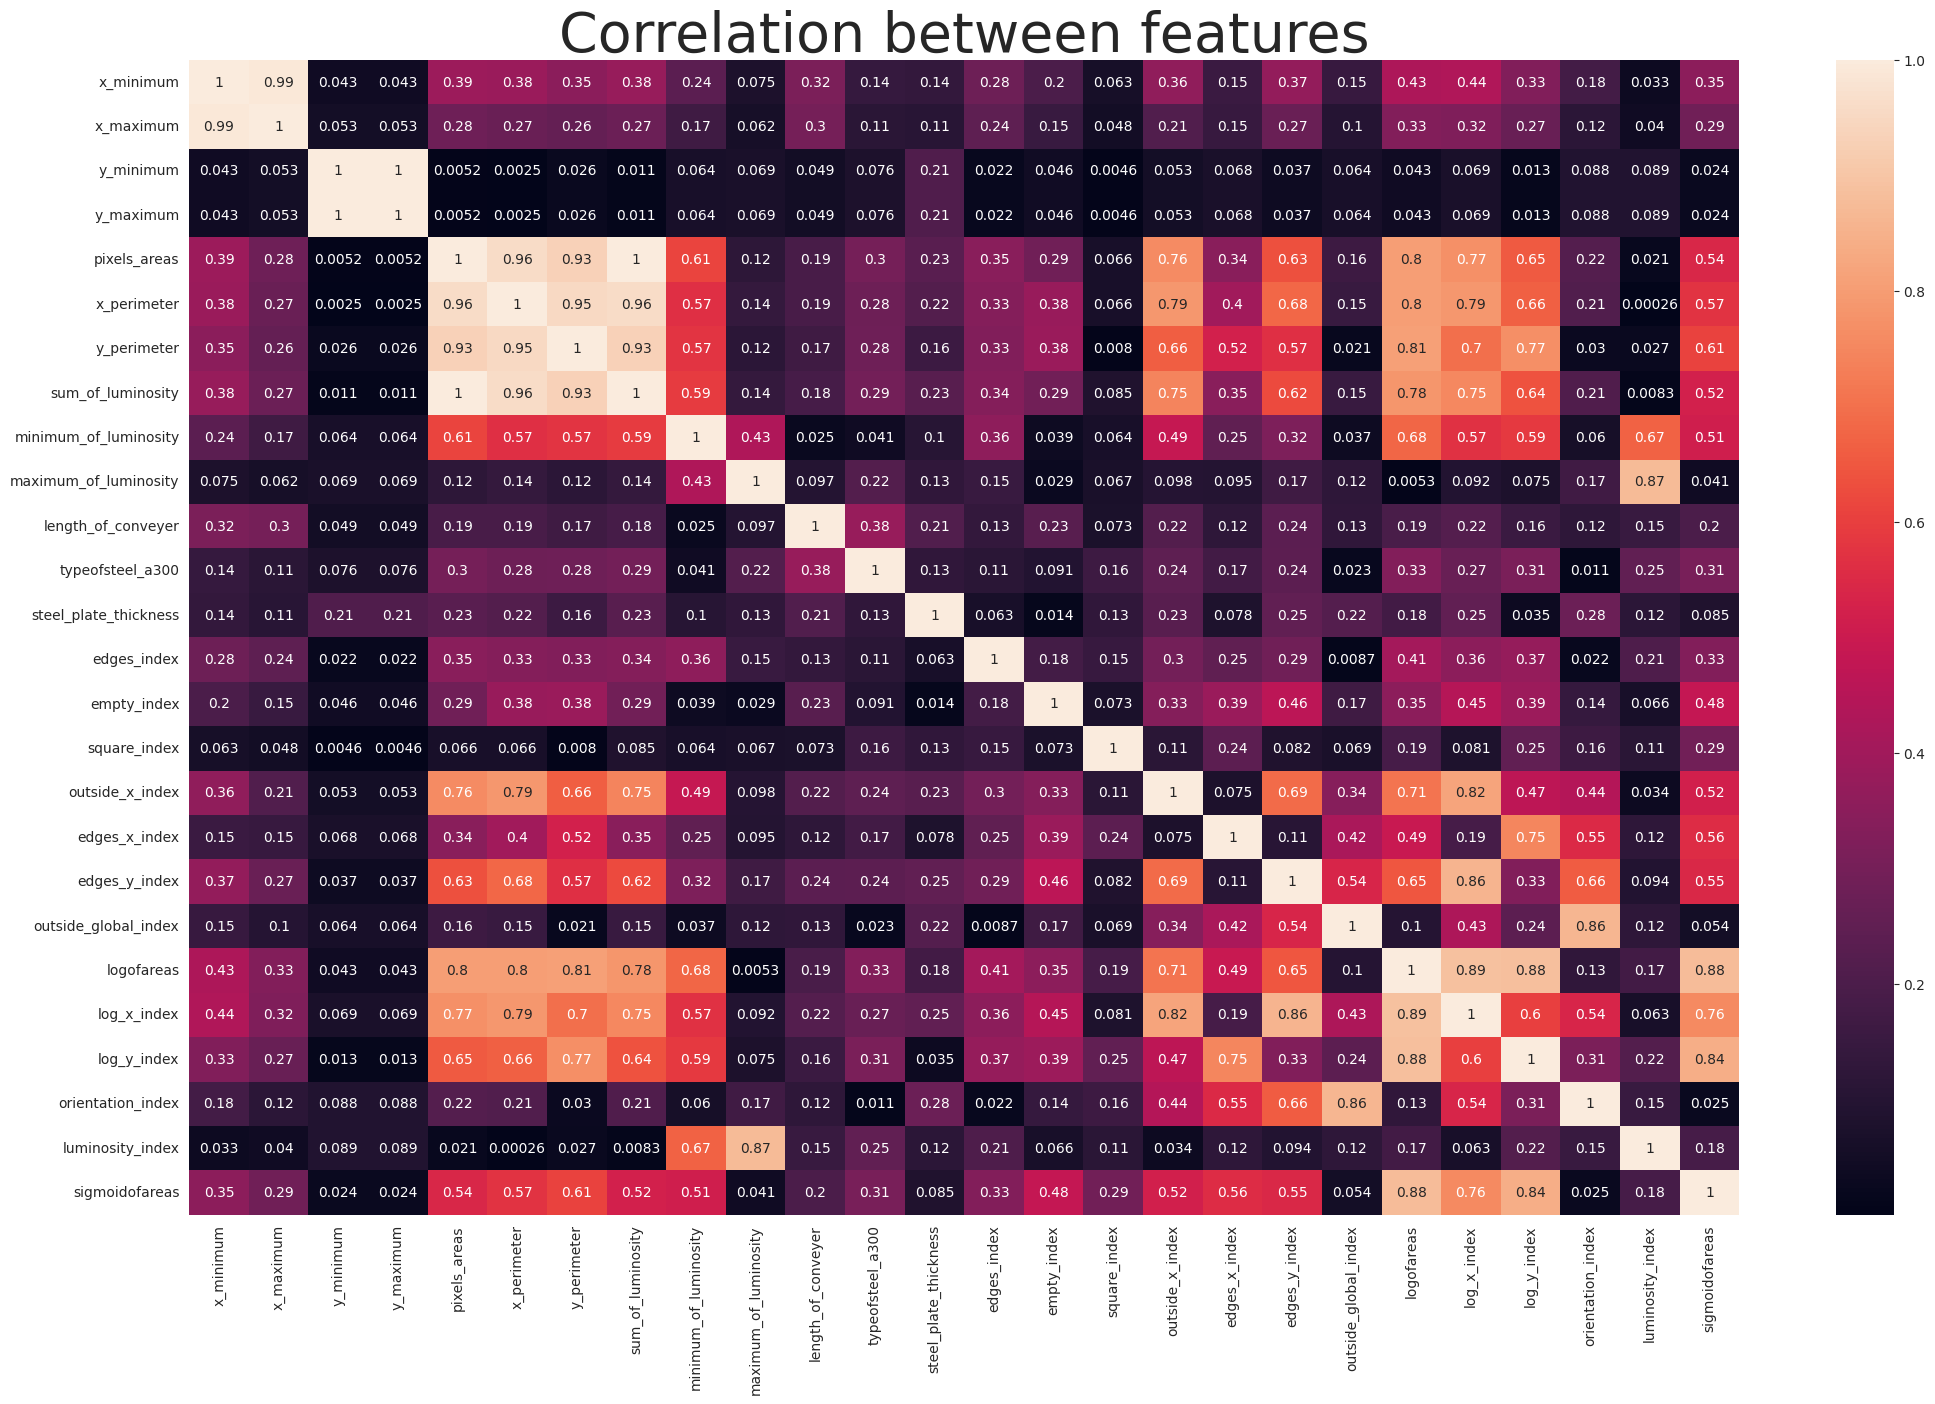

In [23]:
feat_col.remove('typeofsteel_a400')
corr = df[feat_col].corr().abs()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
plt.show()

In [24]:
threshold = 0.9

mask = np.triu(np.ones(corr.shape), k=1)

# Find feature pairs with high correlation
high_corr_pairs = [
    (corr.index[i], corr.columns[j], corr.iloc[i, j])
    for i in range(corr.shape[0])
    for j in range(corr.shape[1])
    if mask[i, j] and corr.iloc[i, j] > threshold
]

high_corr_pairs = pd.DataFrame(high_corr_pairs).T
high_corr_pairs

,0,1,2,3,4,5,6,7
0,x_minimum,y_minimum,pixels_areas,pixels_areas,pixels_areas,x_perimeter,x_perimeter,y_perimeter
1,x_maximum,y_maximum,x_perimeter,y_perimeter,sum_of_luminosity,y_perimeter,sum_of_luminosity,sum_of_luminosity
2,0.988314,1.0,0.959504,0.929943,0.996767,0.952089,0.960622,0.9321


We see that a lot of our features have high correlations between each others, particularly a lot of features have correlation higher than 0.33 (but even 0.7). This means we could use some feature engineering

Plot some relevant features (Pearson corr > 95%) so that we can better see their correlation

In [25]:
corr[corr > 0.95].replace({1.0 : np.nan}).dropna(how = 'all').dropna(axis = 1, how = 'all')

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity
x_minimum,NaN,0.988314,NaN,NaN,NaN,NaN,NaN,NaN
x_maximum,0.988314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_minimum,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
y_maximum,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
pixels_areas,NaN,NaN,NaN,NaN,NaN,0.959504,NaN,0.996767
x_perimeter,NaN,NaN,NaN,NaN,0.959504,NaN,0.952089,0.960622
y_perimeter,NaN,NaN,NaN,NaN,NaN,0.952089,NaN,NaN
sum_of_luminosity,NaN,NaN,NaN,NaN,0.996767,0.960622,NaN,NaN


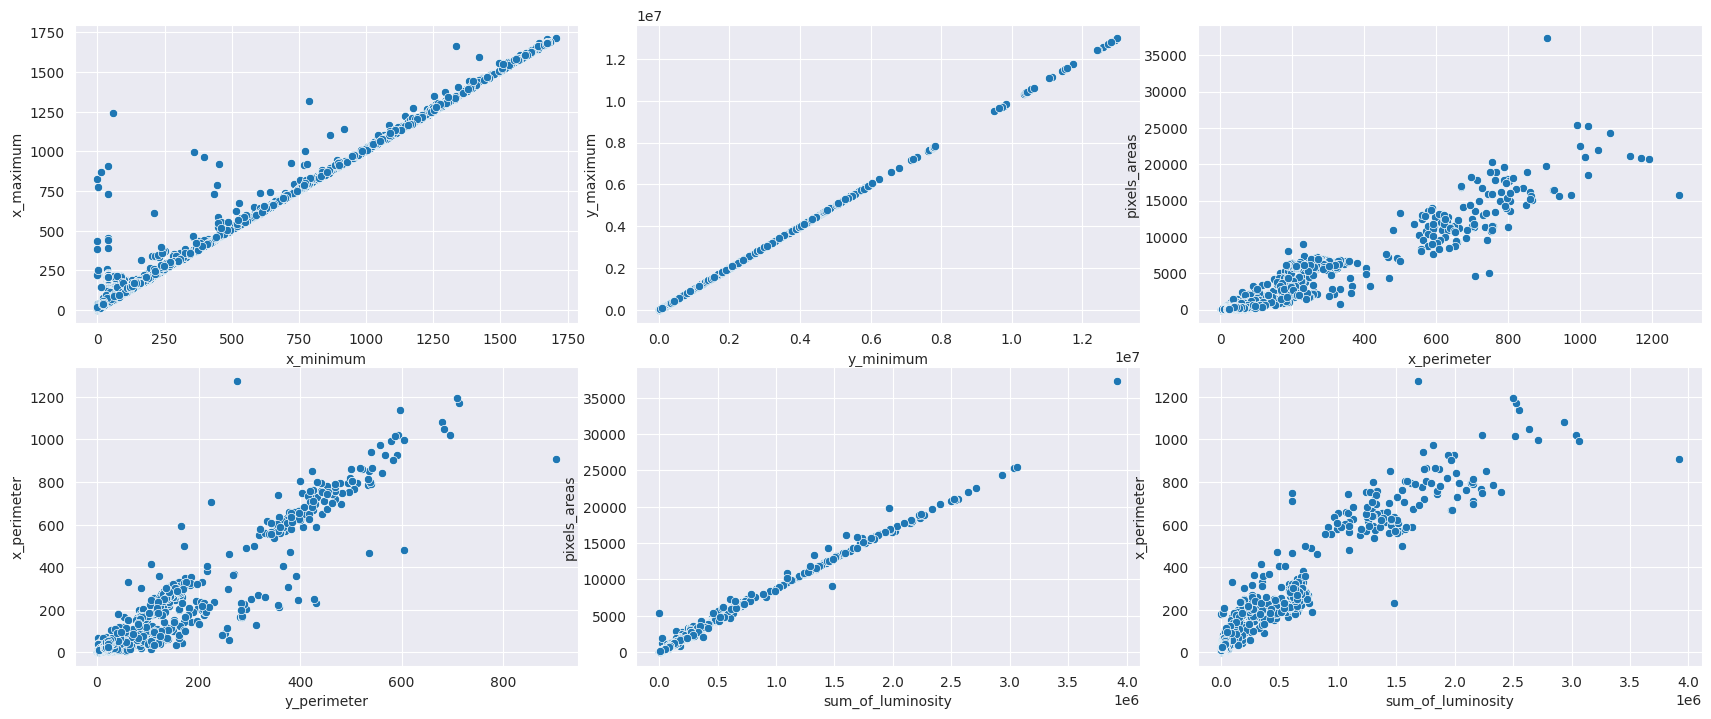

In [26]:
fig, ax = plt.subplots(2, 3, figsize = (17, 7))
plt.tight_layout()
sns.scatterplot(data = df, x = 'x_minimum', y = 'x_maximum', ax = ax[0][0])
sns.scatterplot(data = df, x = 'y_minimum', y = 'y_maximum', ax = ax[0][1])
sns.scatterplot(data = df, x = 'x_perimeter', y = 'pixels_areas', ax = ax[0][2])
sns.scatterplot(data = df, x = 'y_perimeter', y = 'x_perimeter', ax = ax[1][0])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'pixels_areas', ax = ax[1][1])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'x_perimeter', ax = ax[1][2])

plt.show()

We clearly see a strong linearity between the features. Unfortunately, except x_minimum/x_maximum and y_minimum/y_maximum, all the other features are on very different range of data. This means that we can't use simple mean for aggregating some of these features. First, we will need to normalize the data via z-score, and then aggregate some features.

Later in the notebook, dimensionality reduction through UMAP is applied. Since UMAP handles well non-linear relationships, it might not be worth it trying to aggregate all of the highly correlated features. However, we will aggregate the ones displayed in the last graph, since they have almost perfect linear correlation and we will lower the feature dimension, making UMAP more computationally efficient while loosing very little information.

# Balancing the classes/Normalize data

Display how the anomalies are divided in the dataset

In [27]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols
anomaly_count

,count
pastry,158
z_scratch,190
k_scatch,390
stains,72
dirtiness,55
bumps,402
other_faults,673


In [28]:
perc_first_3 = int(anomaly_count.loc[['other_faults', 'bumps', 'k_scatch']].sum()/anomaly_count.sum() * 100)
print(f'The first 3 anomalies count for {perc_first_3}% of the total anomalies')

The first 3 anomalies count for 75% of the total anomalies


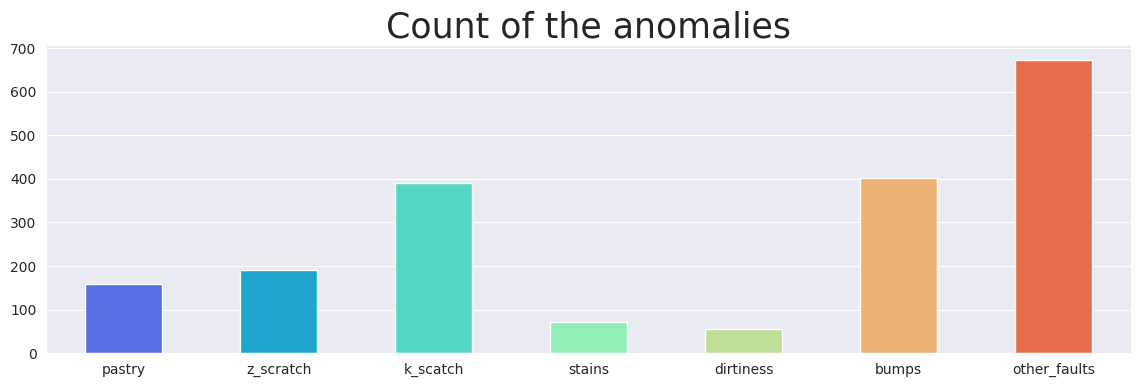

In [29]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count, x = anomaly_count.index, y = 'count', hue = anomaly_count.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Smotenc

In [30]:
df_processed = preprocess_df(df)

df_smotenc = smotenc.smotenc_oversampling(df, ['outside_global_index', 'typeofsteel_a300'], 'anomaly')

bin_cols = ['typeofsteel_a300', 'outside_global_index', 'anomaly']

## CTGan

"Modeling Tabular data using Conditional GAN" paper: https://arxiv.org/abs/1907.00503

In [31]:
# Over-sample with CTGAN, bringing all the classes to 673 samples
df_ctgan = ctgan_oversampling.ctgan_oversampling(df_processed, bin_cols)

Processing anomaly category: 0
Processing anomaly category: 1
Processing anomaly category: 2
Processing anomaly category: 3
Processing anomaly category: 4
Processing anomaly category: 5


KeyboardInterrupt: 

## Smotenc-CTGan

In [ ]:
# Over-sample with CTGAN the data balanced through SMOTENC, bringing all the classes to 2000 samples
df_smotenc_ctgan = ctgan_oversampling.ctgan_oversampling(df_smotenc, bin_cols, 1327, evaluate_data=False)

In [34]:
print('Anomaly count after oversampling with SMOTENC:\n', ctgan_oversampling.sample_count(df_smotenc), '\n-----------------------------')
print('Anomaly count after oversampling with CTGAN:\n', ctgan_oversampling.sample_count(df_ctgan), '\n-----------------------------')
print('Anomaly count after oversampling with SMOTENC-CTGAN:\n', ctgan_oversampling.sample_count(df_smotenc_ctgan), '\n-----------------------------')

Anomaly count after oversampling with SMOTENC:
          count
anomaly       
0          673
1          673
2          673
3          673
4          673
5          673
6          673 
-----------------------------
Anomaly count after oversampling with CTGAN:
          count
anomaly       
0          673
1          673
2          673
3          673
4          673
5          673
6          673 
-----------------------------
Anomaly count after oversampling with SMOTENC-CTGAN:
          count
anomaly       
0         2000
1         2000
2         2000
3         2000
4         2000
5         2000
6         2000 
-----------------------------


EVALUATE SYNTHETIC_DATA

In [35]:
df_smotenc = scale_df(df_smotenc, bin_cols)
df_ctgan = scale_df(df_ctgan, bin_cols).sample(frac=1)
df_smotenc_ctgan = scale_df(df_smotenc_ctgan, bin_cols).sample(frac=1)

'''
df_smotenc.to_csv('csv/smotenc_normalized_steel_plates.csv')
df_ctgan.to_csv('csv/ctgan_normalized_steel_plates.csv')
df_smotenc_ctgan.to_csv('csv/smotenc_ctgan_normalized_steel_plates.csv')'''

In [30]:
paths = [
    'csv/smotenc_normalized_steel_plates.csv',
    'csv/ctgan_normalized_steel_plates.csv',
    'csv/smotenc_ctgan_normalized_steel_plates.csv'
]

method_names_list = ['SMOTENC', 'CTGAN', 'SMOTENC-CTGAN']

best_method = evaluate_synthetic.evaluate_synthetic_data(paths, method_names_list, 'csv/faults.csv')
print(f'The best model for creating synthesized data and balancing the classes is {best_method}')
#df_norm = df_smotenc_ctgan.copy()
df_norm = pd.read_csv('csv/smotenc_ctgan_normalized_steel_plates.csv', index_col=0, header=0).sample(frac=1)
df_norm.reset_index(drop = True, inplace = True)

Processing SMOTENC
Wasserstein distance for SMOTENC is: 0.11878753135201849
----------------------
Processing CTGAN
Wasserstein distance for CTGAN is: 0.1322139293513644
----------------------
Processing SMOTENC-CTGAN
Wasserstein distance for SMOTENC-CTGAN is: 0.11776366206711393
----------------------
The best model for creating synthesized data and balancing the classes is None


In [31]:
anomaly_count_res = pd.DataFrame(df_norm['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

,count
pastry,2000
z_scratch,2000
k_scatch,2000
stains,2000
dirtiness,2000
bumps,2000
other_faults,2000


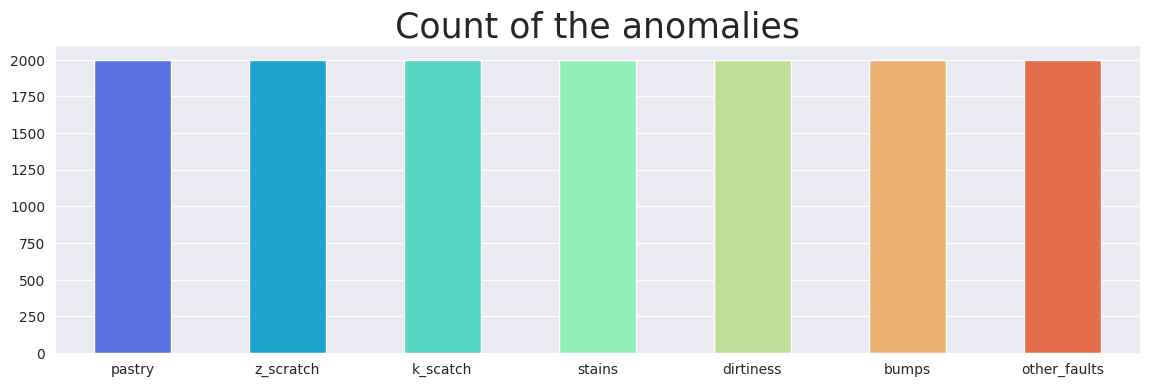

In [32]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count_res, x = anomaly_count_res.index, y = 'count', hue = anomaly_count_res.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [33]:
# check for standardization
norm_dict = {col: [round(df_norm[col].mean()), round(df_norm[col].var())] for col in df_norm.columns}

display(pd.DataFrame(norm_dict, index=['Mean', 'Variance']).drop('anomaly', axis = 1))

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas,typeofsteel_a300,outside_global_index
Mean,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Variance,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


Data has been correcly standardized since the only features that don't have mean = 0 and variance = 1 are the binary features

# Aggregate features

Aggregate features that have high correlation

In [34]:
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum'], axis = 1, inplace = True)

df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)

df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)

df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)

df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)

df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

anomaly_col = df_norm.pop('anomaly')
df_norm['anomaly'] = anomaly_col

# Outlier detection

From the boxplots we can clearly see that the dataset seems to present some outliers. Check if these samples need to be removed or not

In [35]:
df_iqr = df_norm.copy()#.drop(target_cols, axis = 1)
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

In [36]:
# first check how
anomaly_count = pd.DataFrame(df_norm['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols

df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis = 1)]
anomaly_count_iqr = pd.DataFrame(df_iqr['anomaly'].value_counts()).sort_index()
anomaly_count_iqr.index = target_cols

print('How many samples do we have left for each class?')
display(anomaly_count_iqr)
print('\n')

print('How many samples did we remove for each class?')
display(anomaly_count - anomaly_count_iqr)
print('\n')

lost_samples = round((len(df_norm) - len(df_iqr)) / len(df_norm), 2) * 100
print(f"The dataset lost {lost_samples}% of it's samples")
#del df_iqr, anomaly_count_iqr

How many samples do we have left for each class?


,count
pastry,1233
z_scratch,1245
k_scatch,69
stains,1998
dirtiness,1469
bumps,1592
other_faults,950




How many samples did we remove for each class?


,count
pastry,767
z_scratch,755
k_scatch,1931
stains,2
dirtiness,531
bumps,408
other_faults,1050




The dataset lost 39.0% of it's samples


We can see that some anomalies are greatly affected by the IQR outlier deletion. Specifically, k_scratch which was one of the most represented in the initial dataset, lost 640 samples remaining with only 33. Since we loose a lot of representation, and also because such extreme values of the features specifically for k_scratch might not be casual and our models could theoretically learn this relation, choose to use the datasets without IQR applied. Also, 32% of the dataset would be lost if we applied this outlier detection.

# Visualizing the classes

Perform a dimensionality reduction so that we can visualize the classes in a 3 dimensional space.

First try with PCA

In [37]:
X = df_norm.drop('anomaly', axis=1)

In [38]:
pca = PCA(n_components = 3)  
df_PCA = pca.fit_transform(X)
df_PCA = pd.DataFrame(df_PCA, columns = ['PC1', 'PC2', 'PC3'])
df_PCA['anomaly'] = df_norm['anomaly']

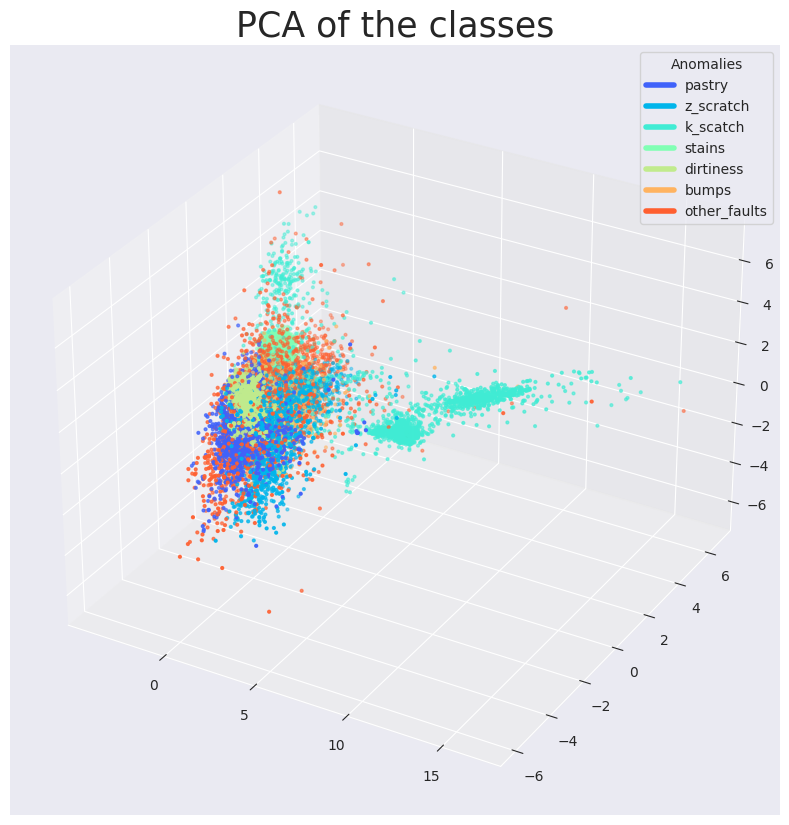

In [39]:
#%matplotlib qtagg 
# uncomment the previous line of code if you want to display interactive plot

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA of the classes', fontsize = 25)
cmap = ListedColormap(palette_hist.as_hex())

ax.scatter(xs = df_PCA['PC1'], ys = df_PCA['PC2'], zs = df_PCA['PC3'], c = df_PCA['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

Seems like PCA doesn't do a great job with this datasets when it comes to visualizing clusters of the classes, perhaps because of the non-linearity of the correlations between the features. 

t-SNE

In [40]:
tsne = TSNE(n_components = 3, random_state = 2)

df_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(df_tsne, columns = ['PC1', 'PC2', 'PC3'])
df_tsne['anomaly'] = df_norm['anomaly']

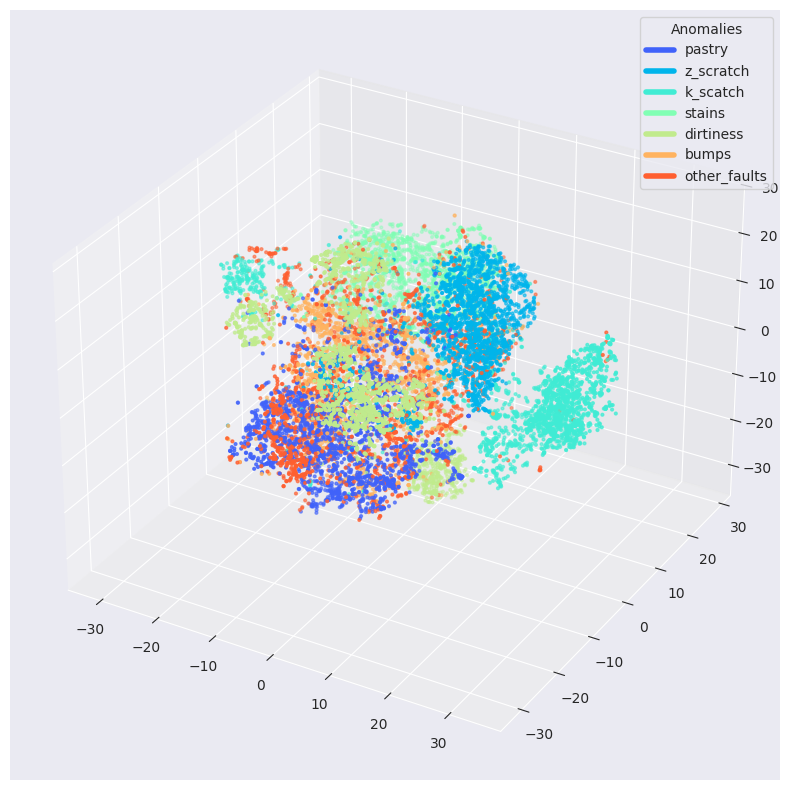

In [41]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')

ax.scatter(df_tsne['PC1'], df_tsne['PC2'], df_tsne['PC3'], c = df_tsne['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP and t-SNE do a better job then PCA when it comes to dimensionality reduction while preserving the clusterization of the different classes. This implies non-linearity in the correlation between the features, and that it might be better to use the UMAP/t-SNE dimensionality reducted dataframes insteand of the original one or the PCA one.

# Models

In [42]:
metrics_df = pd.DataFrame([], columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score


## Naive Bayes

### Without preprocessing

In [43]:
X_full = df.drop('anomaly', axis = 1)
y_full = df['anomaly']

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 47.16%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 45.36%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 48.2%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 45.62%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 47.16%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.75      0.10      0.18        30
           1       0.36      0.73      0.49        37
           2       0.93      0.85      0.89        80
           3 

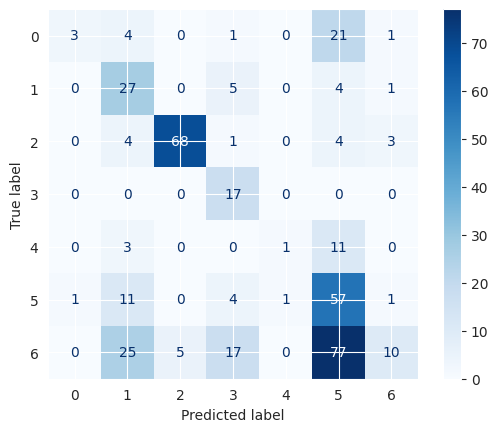

In [44]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_full, y_full):
    y_t = np.array(y_full.iloc[test])

    gnb = GaussianNB()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    gnb.fit(X_full.iloc[train], y_full.iloc[train])
    y_pred = gnb.predict(X_full.iloc[test])

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['Gnb Raw'] = [f'{rounded_mean(acc_per_fold)}%',
                                 f'{rounded_mean(precision_per_fold)}%',
                                 f'{rounded_mean(recall_per_fold)}%',
                                 f'{rounded_mean(f1_per_fold)}%']


    fold_no += 1

In [45]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%


### With preprocessing

In [46]:
df_norm = df_norm.sample(frac = 1)
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 76.21%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 74.29%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 77.07%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 75.64%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 75.57%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       425
           1       0.92      0.82      0.87       386
           2       0.94      0.85      0.89       418
           3

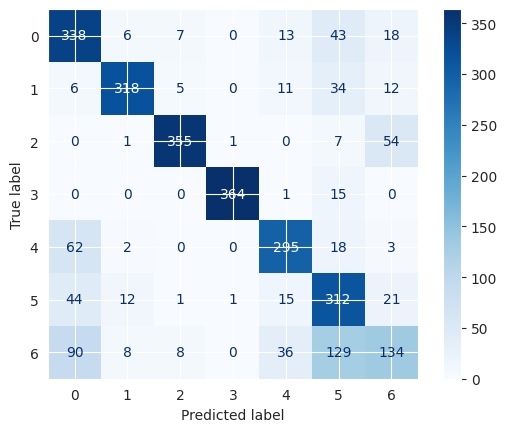

In [47]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    y_t = np.array(y.iloc[test])

    gnb = GaussianNB()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    gnb.fit(X.iloc[train], y.iloc[train])
    y_pred = gnb.predict(X.iloc[test])

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['Gnb'] = [f'{rounded_mean(acc_per_fold)}%',
                                 f'{rounded_mean(precision_per_fold)}%',
                                 f'{rounded_mean(recall_per_fold)}%',
                                 f'{rounded_mean(f1_per_fold)}%']


    fold_no += 1

In [48]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%


As we've seen in the TSNE visualization of the classes, class 5 and 6 are difficultly differentiable. This is confirmed by the the latter confusion matrix. We might try using some hyperparameter tuning/priors/loss balanced learning in the case of the naive bayes classifier

## Support Vector Classifier

### Without parameter hypertuning

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 91.46%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 91.46%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 90.46%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 91.43%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 91.04%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       406
           1       0.95      0.98      0.96       397
           2       0.98      0.95      0.97       408
           3

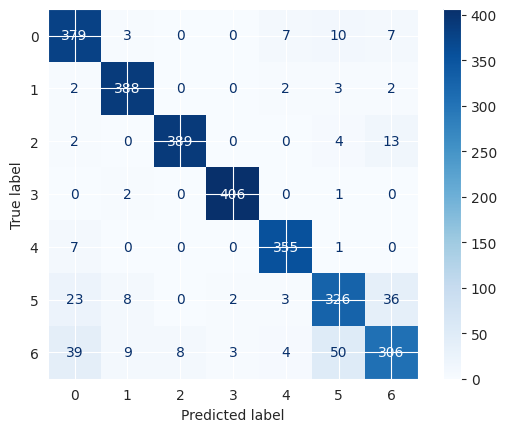

In [49]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    svm = SVC()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    svm.fit(X.iloc[train], y.iloc[train])
    y_t = y.iloc[test]
    y_pred = svm.predict(X.iloc[test])

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['SVM'] = [f'{rounded_mean(acc_per_fold)}%',
                                 f'{rounded_mean(precision_per_fold)}%',
                                 f'{rounded_mean(recall_per_fold)}%',
                                 f'{rounded_mean(f1_per_fold)}%']
    fold_no += 1


In [50]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%
SVM,91.17%,91.12%,91.16%,91.05%


### Hyperparameter tuning for SVM

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 91.82%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 92.39%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 91.29%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 92.39%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 92.14%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       390
           1       0.95      0.97      0.96       398
           2       0.99      0.96      0.97       372
           3

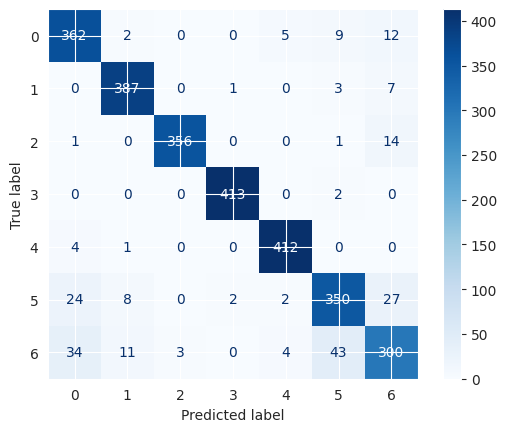

In [51]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    svc = SVC()
    clf = GridSearchCV(svc, parameters, scoring = 'accuracy', refit = True, verbose = 0)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    clf.fit(X.iloc[train], y.iloc[train])

    y_t = y.iloc[test]
    y_pred = clf.predict(X.iloc[test])

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['SVM Grid'] = [f'{rounded_mean(acc_per_fold)}%',
                                      f'{rounded_mean(precision_per_fold)}%',
                                      f'{rounded_mean(recall_per_fold)}%',
                                      f'{rounded_mean(f1_per_fold)}%']
    fold_no += 1


In [52]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%
SVM,91.17%,91.12%,91.16%,91.05%
SVM Grid,92.01%,91.97%,92.02%,91.94%


## Neural Network Classifier

CHECK https://www.tensorflow.org/tutorials/keras/keras_tuner

------------------------------------------------------------------------
Training for fold 1 ...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-03-02 13:06:18.674479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-02 13:06:18.681473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Best hyperparameters for fold 1: {'num_early_layers': 1, 'early_neurons_0': 120, 'dropout_0': 0.2071308492774968, 'num_later_layers': 2, 'later_neurons_0': 64, 'later_neurons_1': 8, 'learning_rate': 0.00049866905809179, 'batch_size': 32}
Accuracy score for fold 1: 91.96%
------------------------------------------------------------------------
Training for fold 2 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 2: {'num_early_layers': 3, 'early_neurons_0': 88, 'dropout_0': 0.15620176007561393, 'early_neurons_1': 104, 'dropout_1': 0.15259011836386305, 'early_neurons_2': 120, 'dropout_2': 0.12930456380416816, 'num_later_layers': 1, 'later_neurons_0': 8, 'learning_rate': 0.004263245435804461, 'batch_size': 128}
Accuracy score for fold 2: 91.43%
------------------------------------------------------------------------
Training for fold 3 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 3: {'num_early_layers': 2, 'early_neurons_0': 112, 'dropout_0': 0.15371004325811216, 'early_neurons_1': 96, 'dropout_1': 0.12860468178256618, 'num_later_layers': 1, 'later_neurons_0': 24, 'learning_rate': 0.002240675216450841, 'batch_size': 256}
Accuracy score for fold 3: 91.93%
------------------------------------------------------------------------
Training for fold 4 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 4: {'num_early_layers': 1, 'early_neurons_0': 112, 'dropout_0': 0.10150800489917385, 'num_later_layers': 3, 'later_neurons_0': 48, 'later_neurons_1': 48, 'later_neurons_2': 40, 'learning_rate': 0.0042728917881137436, 'batch_size': 128}
Accuracy score for fold 4: 91.5%
------------------------------------------------------------------------
Training for fold 5 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 5: {'num_early_layers': 1, 'early_neurons_0': 128, 'dropout_0': 0.2029850983032012, 'num_later_layers': 2, 'later_neurons_0': 48, 'later_neurons_1': 48, 'learning_rate': 0.003180084082530718, 'batch_size': 256}
Accuracy score for fold 5: 91.71%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       406
           1       0.95      0.97      0.96       430
           2       0.94      0.99      0.97       359
           3       0.99      1.00      0.99       390
           4       0.96      0.99      0.97       381
           5       0.83      0.86      0.84       426
           6       0.85      0.73      0.78       408

    accuracy                           0.92      2800
   macro avg       0.92      0.92      0.92      2800
weighted avg       0.92      0.92      0.92      2800



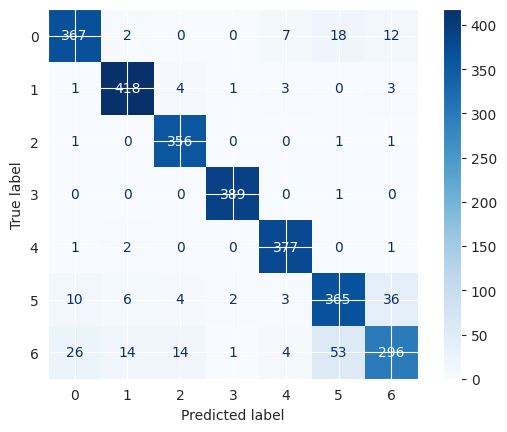

In [53]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    # Define the model architecture
    X_train, X_t = X.iloc[train], X.iloc[test]
    y_train, y_t = y.iloc[train], y.iloc[test]

    # Optuna Study for Hyperparameter Tuning
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction = "maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    study.optimize(lambda trial: nn_optimization.objective(trial, X_train, y_train, X_t, y_t), n_trials = 20, show_progress_bar=True)

    # Train best model on the full training set of the fold
    best_params = study.best_params
    print(f"Best hyperparameters for fold {fold_no}: {best_params}")

    best_model = nn_optimization.create_model(optuna.trial.FixedTrial(best_params), X_train.shape[1])
    best_model.fit(X_train, y_train, batch_size=best_params["batch_size"], epochs=100, verbose=0)

    y_pred = np.argmax(best_model.predict(X_t, verbose=0), axis = 1)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['FF Neural Network'] = [f'{rounded_mean(acc_per_fold)}%',
                                               f'{rounded_mean(precision_per_fold)}%',
                                               f'{rounded_mean(recall_per_fold)}%',
                                               f'{rounded_mean(f1_per_fold)}%']
    # Increase fold number
    fold_no = fold_no + 1

In [54]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%
SVM,91.17%,91.12%,91.16%,91.05%
SVM Grid,92.01%,91.97%,92.02%,91.94%
FF Neural Network,91.71%,91.61%,91.71%,91.57%


## Autoencoder classifier

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 87.5%
Accuracy score for fold 1: 91.79%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 85.57%
Accuracy score for fold 2: 91.54%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 85.82%
Accuracy score for fold 3: 91.36%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 89.46%
Accuracy score for fold 4: 92.75%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 87.18%
Accuracy score for fold 5: 91.68%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 Neural network ...
              precision    recall  f1-score  

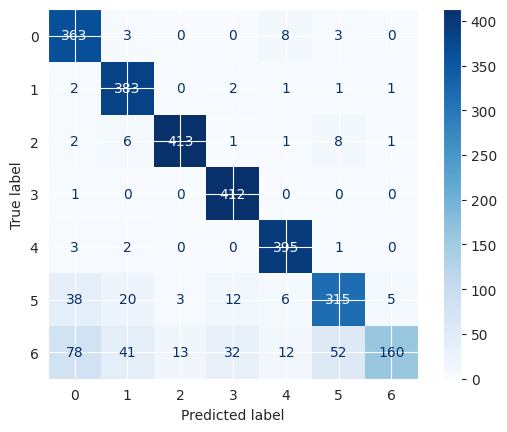

--------------------------------------------------------

Confusion matrix and classification report for fold 5 SVC ...
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       377
           1       0.95      0.95      0.95       390
           2       0.98      0.95      0.96       432
           3       0.99      1.00      0.99       413
           4       0.98      0.97      0.97       401
           5       0.85      0.84      0.84       399
           6       0.81      0.77      0.79       388

    accuracy                           0.92      2800
   macro avg       0.92      0.92      0.92      2800
weighted avg       0.92      0.92      0.92      2800



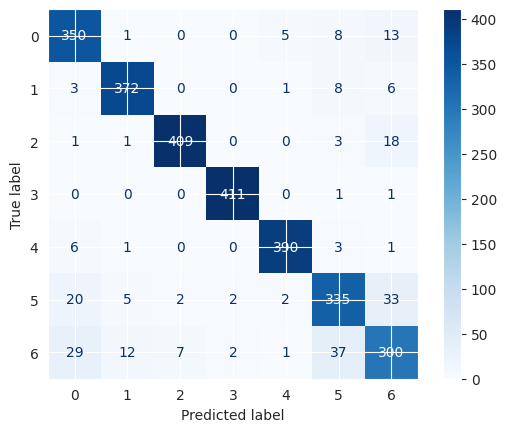

In [55]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

sc = StandardScaler()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

acc_per_fold_nn, precision_per_fold_nn, recall_per_fold_nn, f1_per_fold_nn = [], [], [], []
acc_per_fold_svm, precision_per_fold_svm, recall_per_fold_svm, f1_per_fold_svm = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    # Input layer
    input_layer = Input(shape=(X.shape[1],))

    # Encoder: transformation towards latent space
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    x = Dense(15, activation='relu')(encoded)

    # Decoder: data reconstruction
    encoded = Dense(64, activation='relu')(x)
    encoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    output_reconstruction = Dense(X.shape[1], activation = 'relu', name = "reconstruction")(decoded)

    # Classifier: class prediction
    output_classification = Dense(7, activation = 'softmax', name = "classification")(x)

    # Define the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=[output_reconstruction, output_classification])
    classification = Model(inputs = x, outputs = output_classification)

    # Compile the model with a combined loss
    autoencoder.compile(
                        optimizer = 'adam',
                        loss = {
                            "reconstruction": "mse",
                            "classification": 'sparse_categorical_crossentropy'
                        },
                        loss_weights={"reconstruction": 0.5, "classification": 0.5},
                        metrics = ['mse', 'accuracy']
                        )
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = autoencoder.fit(
    X.iloc[train], [X.iloc[train], y.iloc[train]],  # Input: X, Outputs: [reconstruction, classification]
    batch_size = 256,
    epochs = 100,
    shuffle = True,
    validation_split = 0.2,
    verbose = 0
    )

    # Define encoder model to extract latent features
    encoder = Model(inputs = autoencoder.input, outputs = x)

    # Generate latent representations
    latent_features = encoder.predict(X.iloc[train], verbose = 0)
    latent_features_test = encoder.predict(X.iloc[test], verbose = 0)
    latent_features = sc.fit_transform(latent_features)
    latent_features_test = sc.fit_transform(latent_features_test)

    y_t = y.iloc[test]
    y_pred_nn = classification.predict(latent_features_test, verbose = 0)
    y_pred_nn = np.argmax(y_pred_nn, axis = 1)

    accuracy_nn, precision_nn, recall_nn, f1_nn = metrics_of_prediction(y_t, y_pred_nn, fold_no)

    acc_per_fold_nn.append(accuracy_nn)
    precision_per_fold_nn.append(precision_nn)
    recall_per_fold_nn.append(recall_nn)
    f1_per_fold_nn.append(f1_nn)

    svm_classifier = SVC()
    grid = GridSearchCV(svm_classifier, param_grid, scoring = 'accuracy', refit = True, verbose = 0)
    grid.fit(latent_features, y.iloc[train])
    y_pred_svm = grid.predict(latent_features_test)

    accuracy_svm, precision_svm, recall_svm, f1_svm = metrics_of_prediction(y_t, y_pred_svm, fold_no)

    acc_per_fold_svm.append(accuracy_svm)
    precision_per_fold_svm.append(precision_svm)
    recall_per_fold_svm.append(recall_svm)
    f1_per_fold_svm.append(f1_svm)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} Neural network ...')
        plot_cm(y_t, y_pred_nn)

        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} SVC ...')
        plot_cm(y_t, y_pred_svm)

        metrics_df.loc['AutoEncoder NN Classifier'] = [f'{rounded_mean(acc_per_fold_nn)}%',
                                                       f'{rounded_mean(precision_per_fold_nn)}%',
                                                       f'{rounded_mean(recall_per_fold_nn)}%',
                                                       f'{rounded_mean(f1_per_fold_nn)}%']

        metrics_df.loc['AutoEncoder SVM Classifier'] = [f'{rounded_mean(acc_per_fold_svm)}%',
                                                        f'{rounded_mean(precision_per_fold_svm)}%',
                                                        f'{rounded_mean(recall_per_fold_svm)}%',
                                                        f'{rounded_mean(f1_per_fold_svm)}%']

    fold_no = fold_no + 1

In [56]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%
SVM,91.17%,91.12%,91.16%,91.05%
SVM Grid,92.01%,91.97%,92.02%,91.94%
FF Neural Network,91.71%,91.61%,91.71%,91.57%
AutoEncoder NN Classifier,87.11%,88.01%,87.13%,85.96%
AutoEncoder SVM Classifier,91.82%,91.77%,91.84%,91.78%


## TabNet

"TabNet: Attentive Interpretable Tabular Learning" paper: https://arxiv.org/abs/1908.07442

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 91.07%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 92.0%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 90.64%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 91.0%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 91.04%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       406
           1       0.94      0.95      0.95       391
           2       0.97      0.96      0.97       400
           3  

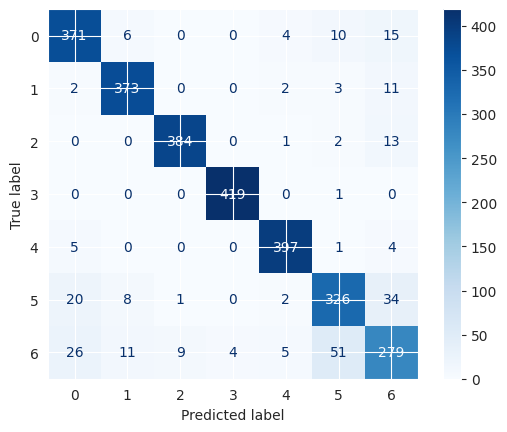

In [62]:
num_splits = 5
k_fold = KFold(n_splits = num_splits)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model = TabNetClassifier()
    # Suppress TabNet's print output
    with contextlib.redirect_stdout(io.StringIO()):
        model.fit(
                np.array(X.iloc[train]), np.array(y.iloc[train]),
                max_epochs=200,
                eval_set=[(np.array(X.iloc[test]), np.array(y.iloc[test]))],
                patience=30,
                batch_size=256
            )
    y_t = y.iloc[test]
    y_pred = model.predict(np.array(X.iloc[test]))

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['TabNet'] = [f'{rounded_mean(acc_per_fold)}%',
                                    f'{rounded_mean(precision_per_fold)}%',
                                    f'{rounded_mean(recall_per_fold)}%',
                                    f'{rounded_mean(f1_per_fold)}%']
    fold_no = fold_no + 1

In [63]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%
SVM,91.17%,91.12%,91.16%,91.05%
SVM Grid,92.01%,91.97%,92.02%,91.94%
FF Neural Network,91.71%,91.61%,91.71%,91.57%
AutoEncoder NN Classifier,87.11%,88.01%,87.13%,85.96%
AutoEncoder SVM Classifier,91.82%,91.77%,91.84%,91.78%
TabNet,91.15%,91.03%,91.13%,91.04%
FTTransformer,92.29%,92.2%,92.28%,92.19%


## FTTransformer

"Revisiting Deep Learning Models for Tabular Data" paper: https://arxiv.org/abs/2106.11959

![Alt Text](https://www.researchgate.net/publication/372985818/figure/fig1/AS:11431281180233791@1691514218219/The-FT-Transformer-architecture-the-proposed-architecture-contains-two-major-blocks.png)

------------------------------------------------------------------------
Training for fold 1 ...


100%|██████████| 50/50 [02:39<00:00,  3.18s/it]


Accuracy score for fold 1: 92.72%
------------------------------------------------------------------------
Training for fold 2 ...


100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


Accuracy score for fold 2: 91.16%
------------------------------------------------------------------------
Training for fold 3 ...


100%|██████████| 50/50 [02:40<00:00,  3.21s/it]


Accuracy score for fold 3: 93.08%
------------------------------------------------------------------------
Training for fold 4 ...


100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


Accuracy score for fold 4: 92.81%
------------------------------------------------------------------------
Training for fold 5 ...


100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


Accuracy score for fold 5: 92.28%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       330
           1       0.96      0.97      0.96       324
           2       0.99      0.98      0.99       313
           3       0.98      1.00      0.99       319
           4       0.97      1.00      0.98       327
           5       0.82      0.85      0.83       313
           6       0.83      0.74      0.78       314

    accuracy                           0.92      2240
   macro avg       0.92      0.92      0.92      2240
weighted avg       0.92      0.92      0.92      2240



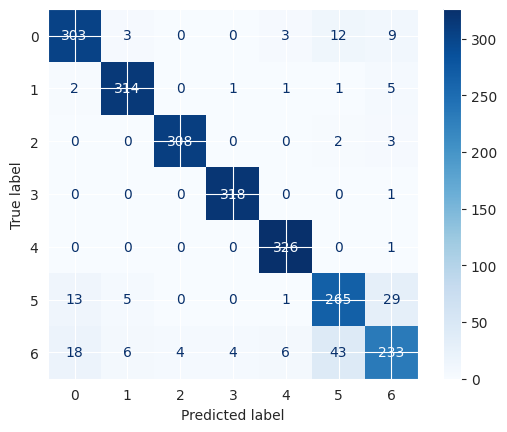

-----------------------------------


In [64]:
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    df_temp = pd.concat([X.iloc[train], y.iloc[train]], ignore_index = True, axis = 1)
    df_temp.columns = df_norm.columns
    df_temp.dropna(inplace = True)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    device = fttransformer.create_device()
    X_num_train, X_num_test, X_cat_train, X_cat_test, y_tr, y_t = fttransformer.create_tensors(df_temp, 'anomaly', ['typeofsteel_a300', 'outside_global_index'], device)
    train_loader = fttransformer.create_dataloader(256, X_num_train, X_cat_train, y_tr)
    cardinalities = fttransformer.get_cardinalities(X_cat_train)

    model, optimizer, loss_fn = fttransformer.compile_transformer(X_num_train.shape[1], cardinalities, 7, device)
    model = fttransformer.train_transformer(model, optimizer, loss_fn, epochs=50, train_loader=train_loader, device=device)

    y_pred = np.array(fttransformer.get_prediction(model, X_num_test, X_cat_test).cpu())
    y_t = np.array(y_t.cpu())

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)
    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        print('-----------------------------------')
        metrics_df.loc['FTTransformer'] = [f'{rounded_mean(acc_per_fold)}%',
                                           f'{rounded_mean(precision_per_fold)}%',
                                           f'{rounded_mean(recall_per_fold)}%',
                                           f'{rounded_mean(f1_per_fold)}%']
    fold_no = fold_no + 1

# Results

In [65]:
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score
Gnb Raw,46.7%,45.05%,51.77%,39.3%
Gnb,75.76%,76.91%,75.76%,75.38%
SVM,91.17%,91.12%,91.16%,91.05%
SVM Grid,92.01%,91.97%,92.02%,91.94%
FF Neural Network,91.71%,91.61%,91.71%,91.57%
AutoEncoder NN Classifier,87.11%,88.01%,87.13%,85.96%
AutoEncoder SVM Classifier,91.82%,91.77%,91.84%,91.78%
TabNet,91.15%,91.03%,91.13%,91.04%
FTTransformer,92.41%,92.37%,92.47%,92.34%
